# Sentinel-1 and Sentinel-2 Data Fusion using Deep Learning

This notebook demonstrates how to:
1. Load Sentinel-1 (SAR) and Sentinel-2 (optical) time series data
2. Apply MOGPR (Multi-Output Gaussian Process Regression) fusion
3. Extract phenological metrics from fused data


## 1. Import Required Libraries

In [1]:
import numpy as np

import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# FuseTS imports
from fusets.mogpr import MOGPRTransformer
from fusets.analytics import phenology
from fusets import whittaker

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Additional imports for shapefile-based masking
import geopandas as gpd
from rasterio.features import rasterize
from rasterio.transform import from_bounds

print("Shapefile processing libraries imported!")

Shapefile processing libraries imported!


## 2. Data Acquisition and Loading from GEE

For this tutorial, we'll create synthetic S1 and S2 time series data. In practice, you would load your actual GeoTIFF stacks or data from other sources.

### 2.1 Steps

⚠️ **STOP! Assets don't exist yet?** Follow these steps first:

### 📋 Prerequisites: Export Data to GEE Assets First

**Before running this notebook, you must:**

1. **Open** `GEE_Data_Preparation_for_FuseTS_Assets.ipynb` 
2. **Run all cells** to export S1/S2 data to GEE Assets
3. **Wait for exports to complete** (check https://code.earthengine.google.com/tasks)
4. **Verify assets exist** at: `projects/ee-geodeticengineeringundip/assets/FuseTS/`

### 🔄 Export Status Check

Go to https://code.earthengine.google.com/tasks and ensure:
- ✅ All 62 period exports show "Completed" status
- ✅ Assets are visible in your GEE asset folder
- ✅ You have read permissions for the assets

### 📥 After Exports Complete

Once data is exported to GEE Assets:
1. Come back to this notebook
2. Set `USE_GEE_ASSETS = True` below
3. Run the data loading cell
4. Continue with MOGPR analysis

**Estimated export time:** 2-6 hours for full Java Island (depends on GEE queue)

### 2.2. 🔍 Quick Check: Do Assets Exist?

Run this cell to verify your GEE Assets are ready:

In [3]:
# Quick check: Verify if GEE Assets exist
import ee

try:
    # Initialize GEE
    try:
        ee.Initialize(project='ee-geodeticengineeringundip')
    except:
        ee.Authenticate()
        ee.Initialize(project='ee-geodeticengineeringundip')
    
    # Check for individual assets (they're not a collection, but separate images)
    asset_base = 'projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2023_Oct2025_Period_'
    
    # Try to load first few periods to verify
    found_periods = []
    missing_periods = []
    
    print("🔍 Checking for individual asset images...")
    for period in range(1, 63):  # Check all 62 periods
        asset_id = f'{asset_base}{period:02d}'
        try:
            img = ee.Image(asset_id)
            # Try to get info to verify it exists
            img.bandNames().getInfo()
            found_periods.append(period)
        except:
            missing_periods.append(period)
    
    print("="*70)
    if len(found_periods) > 0:
        print("✅ SUCCESS! GEE Assets found!")
        print("="*70)
        print(f"📊 Found {len(found_periods)}/62 period images")
        print(f"📁 Asset base: {asset_base}")
        print(f"   Example: {asset_base}01, {asset_base}02, ...")
        
        if len(missing_periods) > 0:
            print(f"\n⚠️  Missing {len(missing_periods)} periods: {missing_periods[:5]}{'...' if len(missing_periods) > 5 else ''}")
            print(f"   Check export status at: https://code.earthengine.google.com/tasks")
        else:
            print(f"\n✅ All 62 periods complete!")
        
        print("\n✅ You can proceed with data loading below!")
        print("   The code will load these individual assets and combine them")
        print("="*70)
    else:
        raise Exception("No assets found")
    
except Exception as e:
    print("="*70)
    print("❌ ASSETS NOT FOUND")
    print("="*70)
    print(f"Error: {str(e)}")
    print("\n🔧 NEXT STEPS:")
    print("1. Open GEE_Data_Preparation_for_FuseTS_Assets.ipynb")
    print("2. Run all cells to export data to GEE Assets")
    print("3. Monitor exports at: https://code.earthengine.google.com/tasks")
    print("4. Wait for all 62 period exports to complete")
    print("5. Come back here and run this check again")
    print("\n⏱️  Export typically takes 2-6 hours for Java Island")
    print("="*70)

🔍 Checking for individual asset images...
✅ SUCCESS! GEE Assets found!
📊 Found 62/62 period images
📁 Asset base: projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2023_Oct2025_Period_
   Example: projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2023_Oct2025_Period_01, projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2023_Oct2025_Period_02, ...

✅ All 62 periods complete!

✅ You can proceed with data loading below!
   The code will load these individual assets and combine them


## 3. LOAD GEE ASSET

In [4]:
# ============================================================================
# OPTION A: Load Real Data from GEE Assets
# ============================================================================

import ee
import geemap
import xarray as xr
import rioxarray

# Configuration
USE_GEE_ASSETS = True  # Set to True to use GEE Assets, False for synthetic data
ASSET_BASE_PATH = 'projects/ee-geodeticengineeringundip/assets/FuseTS'
ASSET_NAME_PREFIX = 'S1_S2_Nov2023_Oct2025_Period_'  # Changed from pattern to prefix
NUM_PERIODS = 62  # Total number of periods to load
OUTPUT_LOCAL_DIR = 'gee_assets_download'

# Region of interest (optional - download specific area)
# Set to None to use full extent from assets
# Your assets contain: Kabupaten Demak (~900 km²)
USE_SMALL_REGION = False  # Set False to use full asset extent (Demak), True for subset only
if USE_SMALL_REGION:
    # Example: Even smaller test region within Demak
    REGION = ee.Geometry.Rectangle([110.40, -6.95, 110.50, -6.85])  # ~10x10 km
    REGION_NAME = 'Demak_Test'
else:
    # Use full extent from assets (Kabupaten Demak)
    REGION = None
    REGION_NAME = 'Demak_Full'

SCALE = 50  # meters (must match your asset export resolution)

def initialize_gee():
    """Initialize Google Earth Engine"""
    try:
        ee.Initialize(project='ee-geodeticengineeringundip')
        print("✅ Earth Engine initialized")
    except Exception as e:
        print(f"Initializing Earth Engine...")
        try:
            ee.Authenticate()
            ee.Initialize(project='ee-geodeticengineeringundip')
            print("✅ Earth Engine authenticated and initialized")
        except Exception as e2:
            print(f"❌ Error: {e2}")
            raise

def load_gee_assets_to_xarray(asset_base_path, name_prefix, num_periods=62, region=None, scale=50):
    """
    Load individual GEE Asset images and convert to xarray Dataset compatible with FuseTS
    
    Parameters:
    -----------
    asset_base_path : str
        Base path to GEE assets folder
    name_prefix : str
        Prefix for asset names (e.g., 'S1_S2_Nov2024_Oct2025_Period_')
    num_periods : int
        Number of periods to load (default 62)
    region : ee.Geometry, optional
        Region to download. If None, uses full asset extent
    scale : int
        Resolution in meters
        
    Returns:
    --------
    xr.Dataset with proper FuseTS format
    """
    import os
    import numpy as np
    from datetime import datetime, timedelta
    
    print(f"🔍 Loading {num_periods} individual assets from: {asset_base_path}/")
    print(f"   Asset name pattern: {name_prefix}01, {name_prefix}02, ...")
    
    # Create output directory
    os.makedirs(OUTPUT_LOCAL_DIR, exist_ok=True)
    
    # Storage for time series data
    all_vv = []
    all_vh = []
    all_ndvi = []
    time_coords = []
    
    # Load first asset to get spatial dimensions
    first_asset_id = f'{asset_base_path}/{name_prefix}01'
    first_img = ee.Image(first_asset_id)
    
    # Determine region from first asset if not specified
    if region is None:
        region = first_img.geometry().bounds()
        print(f"   Using full asset extent")
    
    # Get first image info
    bands = first_img.bandNames().getInfo()
    print(f"   Bands per period: {bands}")
    print(f"\n📥 Downloading {num_periods} periods at {scale}m resolution...")
    print(f"   This will take several minutes...")
    
    # Download each period individually
    for period in range(1, num_periods + 1):
        asset_id = f'{asset_base_path}/{name_prefix}{period:02d}'
        
        try:
            # Load asset
            img = ee.Image(asset_id)
            
            # Download this period
            output_file = os.path.join(OUTPUT_LOCAL_DIR, f'period_{period:02d}.tif')
            
            if not os.path.exists(output_file):
                print(f"   Downloading period {period}/{num_periods}...", end=' ')
                
                try:
                    geemap.download_ee_image(
                        img,
                        filename=output_file,
                        region=region,
                        scale=scale,
                        crs='EPSG:4326'
                    )
                    print("✓")
                except Exception as e:
                    print(f"✗ Failed: {e}")
                    continue
            else:
                print(f"   Period {period}/{num_periods}: Using cached file ✓")
            
            # Load the GeoTIFF
            period_data = rioxarray.open_rasterio(output_file)
            
            # Extract bands (assuming order: VV, VH, S2ndvi or NDVI)
            if len(period_data.band) >= 3:
                vv = period_data.isel(band=0).values  # First band = VV
                vh = period_data.isel(band=1).values  # Second band = VH
                ndvi = period_data.isel(band=2).values  # Third band = NDVI/S2ndvi
            else:
                print(f"   ⚠️  Period {period} has only {len(period_data.band)} bands, expected 3")
                continue
            
            all_vv.append(vv)
            all_vh.append(vh)
            all_ndvi.append(ndvi)
            
            # Calculate time coordinate (center of 12-day period starting Nov 1, 2024)
            start_date = datetime(2024, 11, 1)
            period_center = start_date + timedelta(days=(period-1)*12 + 6)
            time_coords.append(period_center)
            
            # Store spatial coords from first period
            if period == 1:
                y_coords = period_data.y.values
                x_coords = period_data.x.values
                
        except Exception as e:
            print(f"   ⚠️  Warning: Could not load period {period}: {e}")
    
    # Check if we got any data
    if len(all_vv) == 0:
        print("\n❌ No data loaded!")
        return None
    
    print(f"\n✅ Successfully loaded {len(all_vv)} periods")
    
    # Stack into numpy arrays
    vv_stack = np.stack(all_vv, axis=0)  # Shape: (time, y, x)
    vh_stack = np.stack(all_vh, axis=0)
    ndvi_stack = np.stack(all_ndvi, axis=0)
    
    # Create FuseTS-compatible xarray Dataset
    ds = xr.Dataset({
        'VV': (['t', 'y', 'x'], vv_stack),
        'VH': (['t', 'y', 'x'], vh_stack),
        'S2ndvi': (['t', 'y', 'x'], ndvi_stack)
    }, coords={
        't': time_coords,
        'y': y_coords,
        'x': x_coords
    })
    
    # Add metadata
    ds.attrs.update({
        'title': 'Sentinel-1/2 Time Series from GEE Assets',
        'source': f'{asset_base_path}/{name_prefix}',
        'temporal_resolution': '12-day composites',
        'spatial_resolution': f'{scale}m',
        'date_range': f'{time_coords[0].strftime("%Y-%m-%d")} to {time_coords[-1].strftime("%Y-%m-%d")}',
        'num_periods': len(time_coords),
        'region': 'Kabupaten Demak',
        'crs': 'EPSG:4326',
        'fusets_ready': True
    })
    
    print(f"\n📊 Dataset Summary:")
    print(f"   Shape: {ds.VV.shape} (time, y, x)")
    print(f"   Time range: {time_coords[0].strftime('%Y-%m-%d')} to {time_coords[-1].strftime('%Y-%m-%d')}")
    print(f"   Spatial extent: {len(y_coords)} x {len(x_coords)} pixels")
    print(f"   Bands: VV, VH, S2ndvi")
    
    return ds
    
    # Create ImageCollection from list
    collection = ee.ImageCollection(image_list)
    
    # Get collection info
    count = len(image_list)
    print(f"   Successfully loaded {count}/{num_periods} images")
    
    if count == 0:
        print("❌ No images found! Check:")
        print(f"   1. Asset path: {full_pattern}")
        print(f"   2. Asset permissions (must be readable)")
        print(f"   3. Export tasks completed successfully")
        return None
    
    # Get first image to check bands
    first = ee.Image(collection.first())
    bands = first.bandNames().getInfo()
    print(f"   Bands found: {bands}")
    
    # Determine region
    if region is None:
        region = collection.geometry().bounds()
        print(f"   Using full asset extent")
    else:
        print(f"   Using custom region: {region.bounds().getInfo()}")
    
    # Download collection as multi-band image
    print(f"\n📥 Downloading data at {scale}m resolution...")
    print(f"   This may take a few minutes depending on region size...")
    
    # Convert collection to multi-band image with period labels
    image_list = collection.toList(count)
    
    def add_period_suffix(image):
        img = ee.Image(image)
        period = ee.Number(img.get('period')).format('%02d')
        old_names = img.bandNames()
        new_names = old_names.map(lambda name: ee.String(name).cat('_P').cat(period))
        return img.rename(new_names).copyProperties(img, img.propertyNames())
    
    renamed_collection = collection.map(add_period_suffix)
    multi_band_image = renamed_collection.toBands()
    
    # Use geemap for efficient download
    import os
    os.makedirs(OUTPUT_LOCAL_DIR, exist_ok=True)
    
    output_file = os.path.join(OUTPUT_LOCAL_DIR, f'{REGION_NAME}_S1_S2_timeseries.tif')
    
    # Download using geemap
    try:
        geemap.download_ee_image(
            multi_band_image,
            filename=output_file,
            region=region,
            scale=scale,
            crs='EPSG:4326'
        )
        print(f"✅ Downloaded to: {output_file}")
    except Exception as e:
        print(f"⚠️  Direct download failed: {e}")
        print(f"   Trying alternative download method...")
        
        # Alternative: get download URL
        url = multi_band_image.getDownloadURL({
            'scale': scale,
            'crs': 'EPSG:4326',
            'region': region,
            'format': 'GEO_TIFF'
        })
        print(f"\n📎 Download URL generated:")
        print(f"   {url}")
        print(f"\n   Copy this URL to your browser to download the file")
        print(f"   Then save it as: {output_file}")
        print(f"   After download completes, re-run this cell to load the data")
        
        # Check if file exists from previous download
        if os.path.exists(output_file):
            print(f"\n✅ Found existing file: {output_file}")
        else:
            return None
    
    # Load the downloaded GeoTIFF
    print(f"\n📖 Loading GeoTIFF into xarray...")
    data_raster = rioxarray.open_rasterio(output_file)
    
    # Parse band names to extract periods and create proper dataset
    band_names = [str(b) for b in data_raster.band.values]
    print(f"   Total bands: {len(band_names)}")
    
    # Parse periods from band names (format: VV_P01, VH_P01, S2ndvi_P01, etc.)
    periods = sorted(list(set([int(b.split('_P')[1]) for b in band_names if '_P' in b])))
    n_periods = len(periods)
    print(f"   Periods found: {n_periods} ({min(periods)} to {max(periods)})")
    
    # Reorganize into proper time series format
    vv_data = []
    vh_data = []
    ndvi_data = []
    
    for period in periods:
        # Extract bands for this period
        vv_band = f'VV_P{period:02d}'
        vh_band = f'VH_P{period:02d}'
        ndvi_band = f'S2ndvi_P{period:02d}'
        
        # Find band indices
        vv_idx = [i for i, b in enumerate(band_names) if b.endswith(vv_band)]
        vh_idx = [i for i, b in enumerate(band_names) if b.endswith(vh_band)]
        ndvi_idx = [i for i, b in enumerate(band_names) if b.endswith(ndvi_band)]
        
        if vv_idx and vh_idx and ndvi_idx:
            vv_data.append(data_raster.isel(band=vv_idx[0]))
            vh_data.append(data_raster.isel(band=vh_idx[0]))
            ndvi_data.append(data_raster.isel(band=ndvi_idx[0]))
    
    # Stack into time dimension
    vv_array = xr.concat(vv_data, dim='time')
    vh_array = xr.concat(vh_data, dim='time')
    ndvi_array = xr.concat(ndvi_data, dim='time')
    
    # Create time coordinates (assuming 12-day periods starting Nov 1, 2024)
    from datetime import datetime, timedelta
    start_date = datetime(2024, 11, 1)
    time_coords = [start_date + timedelta(days=(p-1)*12 + 6) for p in periods]  # Center of each period
    
    # Create proper FuseTS-compatible dataset
    ds = xr.Dataset({
        'VV': (['time', 'y', 'x'], vv_array.values),
        'VH': (['time', 'y', 'x'], vh_array.values),
        'S2ndvi': (['time', 'y', 'x'], ndvi_array.values)
    }, coords={
        'time': time_coords,
        'y': vv_array.y.values,
        'x': vv_array.x.values
    })
    
    # Rename time dimension to 't' for FuseTS compatibility
    ds = ds.rename({'time': 't'})
    
    # Add metadata
    ds.attrs.update({
        'title': 'Sentinel-1/2 Time Series from GEE Assets',
        'source': f'{asset_base_path}/{name_prefix}',
        'temporal_resolution': '12-day composites',
        'spatial_resolution': f'{scale}m',
        'date_range': f'{time_coords[0].strftime("%Y-%m-%d")} to {time_coords[-1].strftime("%Y-%m-%d")}',
        'region': REGION_NAME,
        'crs': 'EPSG:4326',
        'fusets_ready': True
    })
    
    print(f"\n✅ Dataset created successfully!")
    print(f"   Shape: {ds.VV.shape}")
    print(f"   Time range: {time_coords[0]} to {time_coords[-1]}")
    print(f"   Spatial extent: {len(ds.y)} x {len(ds.x)} pixels")
    
    return ds

# Execute if using GEE Assets
if USE_GEE_ASSETS:
    print("="*70)
    print("🌍 LOADING DATA FROM GEE ASSETS")
    print("="*70)
    
    # Initialize GEE
    initialize_gee()
    
    # Load assets
    gee_dataset = load_gee_assets_to_xarray(
        ASSET_BASE_PATH,
        ASSET_NAME_PREFIX,
        num_periods=NUM_PERIODS,
        region=REGION,
        scale=SCALE
    )
    
    if gee_dataset is not None:
        print("\n" + "="*70)
        print("📊 DATASET SUMMARY")
        print("="*70)
        print(gee_dataset)
        print("\n✅ Data ready for MOGPR processing!")
        print("   Skip the synthetic data generation below and use 'gee_dataset'")
    else:
        print("\n⚠️  Failed to load GEE Assets")
        print("   Falling back to synthetic data generation...")
        USE_GEE_ASSETS = False
        
else:
    print("ℹ️  Using synthetic data (USE_GEE_ASSETS=False)")
    print("   To use GEE Assets, set USE_GEE_ASSETS=True above")
    gee_dataset = None

🌍 LOADING DATA FROM GEE ASSETS
✅ Earth Engine initialized
🔍 Loading 62 individual assets from: projects/ee-geodeticengineeringundip/assets/FuseTS/
   Asset name pattern: S1_S2_Nov2023_Oct2025_Period_01, S1_S2_Nov2023_Oct2025_Period_02, ...
   Using full asset extent
   Bands per period: ['VV', 'VH', 'S2ndvi']

📥 Downloading 62 periods at 50m resolution...
   This will take several minutes...
   Period 1/62: Using cached file ✓
   Period 2/62: Using cached file ✓
   Period 3/62: Using cached file ✓
   Period 4/62: Using cached file ✓
   Period 5/62: Using cached file ✓
   Period 6/62: Using cached file ✓
   Period 7/62: Using cached file ✓
   Period 8/62: Using cached file ✓
   Period 9/62: Using cached file ✓
   Period 10/62: Using cached file ✓
   Period 11/62: Using cached file ✓
   Period 12/62: Using cached file ✓
   Period 13/62: Using cached file ✓
   Period 14/62: Using cached file ✓
   Period 15/62: Using cached file ✓
   Period 16/62: Using cached file ✓
   Period 17/62: Using

## 3.5. Load and Apply Paddy Field Mask

This section loads the paddy field shapefile and applies it as a mask to the dataset, ensuring that only paddy field pixels are analyzed in subsequent steps.

🗺️  LOADING AND APPLYING PADDY FIELD MASK

Dataset to mask: gee_dataset
Dataset shape: FrozenMappingWarningOnValuesAccess({'t': 62, 'y': 892, 'x': 1170})

✅ Shapefile loaded successfully
   Features: 1043
   CRS: EPSG:4326
   Bounds: [110.517654  -7.108495 111.033707  -6.717609]

📐 Dataset spatial info:
   Grid size: 892 rows × 1170 columns
   X range: [110.513217, 111.038282]
   Y range: [-7.113085, -6.712886]
   Pixel resolution: 0.000449° × 0.000449°

🔧 Rasterization transform created

⏳ Rasterizing shapefile geometries...

✅ Paddy mask created successfully!

📊 Mask Statistics:
   Total pixels:      1,043,640
   Paddy pixels:      227,084 (21.76%)
   Non-paddy pixels:  816,556 (78.24%)

🎯 Applying mask to dataset variables...
   VV: 64,705,680 → 14,079,208 valid pixels (21.8% retained)
   VH: 64,705,680 → 14,079,208 valid pixels (21.8% retained)
   S2ndvi: 64,705,680 → 14,079,208 valid pixels (21.8% retained)

✅ Masking complete! Dataset updated with paddy-only pixels.
   Mask also 

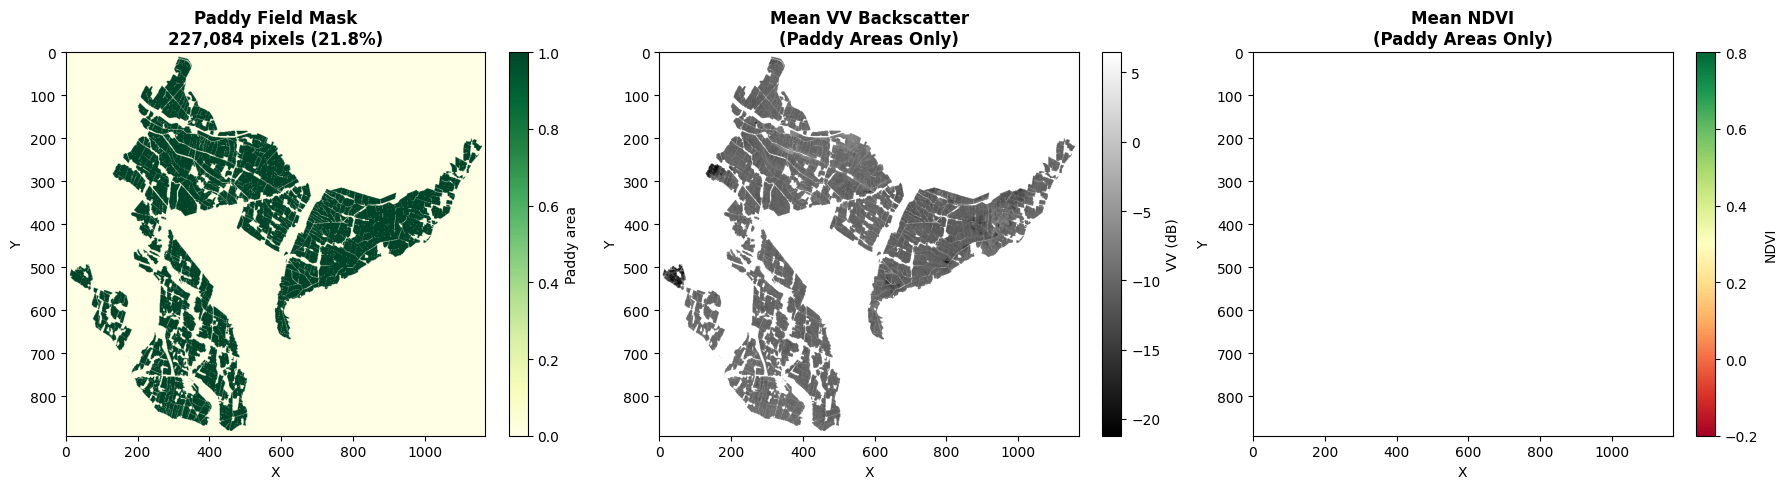


💾 Validation plot saved as 'paddy_mask_applied.png'



In [5]:
# ============================================================================
# LOAD SHAPEFILE AND APPLY PADDY FIELD MASK
# ============================================================================

print("=" * 70)
print("🗺️  LOADING AND APPLYING PADDY FIELD MASK")
print("=" * 70)

# Check if combined_dataset exists
if 'combined_dataset' in locals() or 'gee_dataset' in locals():
    # Use whichever dataset is available
    if 'combined_dataset' in locals():
        dataset_to_mask = combined_dataset
        dataset_name = 'combined_dataset'
    else:
        dataset_to_mask = gee_dataset
        dataset_name = 'gee_dataset'
        
    print(f"\nDataset to mask: {dataset_name}")
    print(f"Dataset shape: {dataset_to_mask.dims}")
    
    # Step 1: Load shapefile
    shapefile_path = '/home/unika_sianturi/work/FuseTS/data/klambu-glapan.shp'
    
    try:
        paddy_gdf = gpd.read_file(shapefile_path)
        print(f"\n✅ Shapefile loaded successfully")
        print(f"   Features: {len(paddy_gdf)}")
        print(f"   CRS: {paddy_gdf.crs}")
        print(f"   Bounds: {paddy_gdf.total_bounds}")
        
        # Step 2: Reproject shapefile to match dataset CRS (EPSG:4326)
        if paddy_gdf.crs != 'EPSG:4326':
            print(f"\n🔄 Reprojecting shapefile from {paddy_gdf.crs} to EPSG:4326...")
            paddy_gdf = paddy_gdf.to_crs('EPSG:4326')
            print(f"   New bounds: {paddy_gdf.total_bounds}")
        
        # Step 3: Get dataset spatial information
        x_coords = dataset_to_mask.coords['x'].values
        y_coords = dataset_to_mask.coords['y'].values
        ny, nx = len(y_coords), len(x_coords)
        
        print(f"\n📐 Dataset spatial info:")
        print(f"   Grid size: {ny} rows × {nx} columns")
        print(f"   X range: [{x_coords.min():.6f}, {x_coords.max():.6f}]")
        print(f"   Y range: [{y_coords.min():.6f}, {y_coords.max():.6f}]")
        
        # Calculate pixel resolution
        x_res = (x_coords[-1] - x_coords[0]) / (nx - 1) if nx > 1 else 0.0005
        y_res = (y_coords[0] - y_coords[-1]) / (ny - 1) if ny > 1 else 0.0005  # y is descending
        
        print(f"   Pixel resolution: {abs(x_res):.6f}° × {abs(y_res):.6f}°")
        
        # Step 4: Create rasterization transform
        # Note: y_coords typically descend (north to south), so y_coords[0] is north
        transform = from_bounds(
            west=x_coords[0] - abs(x_res)/2,
            south=y_coords[-1] - abs(y_res)/2,
            east=x_coords[-1] + abs(x_res)/2,
            north=y_coords[0] + abs(y_res)/2,
            width=nx,
            height=ny
        )
        
        print(f"\n🔧 Rasterization transform created")
        
        # Step 5: Rasterize shapefile to create mask
        print(f"\n⏳ Rasterizing shapefile geometries...")
        
        from rasterio.features import geometry_mask
        
        # geometry_mask returns True for pixels OUTSIDE geometries
        # We want True for pixels INSIDE, so we invert with ~
        paddy_mask_array = ~geometry_mask(
            paddy_gdf.geometry,
            out_shape=(ny, nx),
            transform=transform,
            invert=False
        )
        
        # Step 6: Create xarray DataArray for the mask
        paddy_mask = xr.DataArray(
            paddy_mask_array,
            dims=['y', 'x'],
            coords={'y': y_coords, 'x': x_coords},
            name='paddy_mask'
        )
        
        # Step 7: Calculate and print statistics
        total_pixels = paddy_mask.size
        paddy_pixels = paddy_mask.sum().values
        non_paddy_pixels = total_pixels - paddy_pixels
        
        print(f"\n✅ Paddy mask created successfully!")
        print(f"\n📊 Mask Statistics:")
        print(f"   Total pixels:      {total_pixels:,}")
        print(f"   Paddy pixels:      {int(paddy_pixels):,} ({100*paddy_pixels/total_pixels:.2f}%)")
        print(f"   Non-paddy pixels:  {int(non_paddy_pixels):,} ({100*non_paddy_pixels/total_pixels:.2f}%)")
        
        # Step 8: Apply mask to all variables in the dataset
        print(f"\n🎯 Applying mask to dataset variables...")
        
        # Create masked dataset
        combined_dataset_masked = dataset_to_mask.copy()
        
        for var in ['VV', 'VH', 'S2ndvi']:
            if var in combined_dataset_masked:
                # Count valid pixels before masking
                before_valid = (~np.isnan(combined_dataset_masked[var].values)).sum()
                
                # Apply mask using .where() - keeps values where mask is True, sets to NaN elsewhere
                combined_dataset_masked[var] = combined_dataset_masked[var].where(paddy_mask)
                
                # Count valid pixels after masking
                after_valid = (~np.isnan(combined_dataset_masked[var].values)).sum()
                
                print(f"   {var}: {before_valid:,} → {after_valid:,} valid pixels "
                      f"({100*after_valid/before_valid:.1f}% retained)")
        
        # Update the dataset variable
        if dataset_name == 'combined_dataset':
            combined_dataset = combined_dataset_masked
        else:
            gee_dataset = combined_dataset_masked
            # Also create combined_dataset if it doesn't exist
            combined_dataset = combined_dataset_masked
        
        # Add mask as a variable to the dataset for later use
        combined_dataset['paddy_mask'] = paddy_mask
        
        print(f"\n✅ Masking complete! Dataset updated with paddy-only pixels.")
        print(f"   Mask also saved as 'paddy_mask' variable in dataset.")
        
        # Quick visualization
        print(f"\n📊 Creating validation plot...")
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot 1: Paddy mask
        im1 = axes[0].imshow(paddy_mask, cmap='YlGn', aspect='auto')
        axes[0].set_title(f'Paddy Field Mask\n{int(paddy_pixels):,} pixels ({100*paddy_pixels/total_pixels:.1f}%)', 
                         fontsize=12, fontweight='bold')
        plt.colorbar(im1, ax=axes[0], label='Paddy area', fraction=0.046)
        axes[0].set_xlabel('X')
        axes[0].set_ylabel('Y')
        
        # Plot 2: Mean VV (masked)
        vv_mean = combined_dataset['VV'].mean(dim='t')
        im2 = axes[1].imshow(vv_mean, cmap='gray', aspect='auto')
        axes[1].set_title('Mean VV Backscatter\n(Paddy Areas Only)', fontsize=12, fontweight='bold')
        plt.colorbar(im2, ax=axes[1], label='VV (dB)', fraction=0.046)
        axes[1].set_xlabel('X')
        axes[1].set_ylabel('Y')
        
        # Plot 3: Mean NDVI (masked)
        ndvi_mean = combined_dataset['S2ndvi'].mean(dim='t')
        im3 = axes[2].imshow(ndvi_mean, cmap='RdYlGn', vmin=-0.2, vmax=0.8, aspect='auto')
        axes[2].set_title('Mean NDVI\n(Paddy Areas Only)', fontsize=12, fontweight='bold')
        plt.colorbar(im3, ax=axes[2], label='NDVI', fraction=0.046)
        axes[2].set_xlabel('X')
        axes[2].set_ylabel('Y')
        
        plt.tight_layout()
        plt.savefig('paddy_mask_applied.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n💾 Validation plot saved as 'paddy_mask_applied.png'")
        
    except FileNotFoundError:
        print(f"\n❌ Error: Shapefile not found at {shapefile_path}")
        print(f"   Please verify the path and try again.")
    except Exception as e:
        print(f"\n❌ Error applying mask: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("\n⚠️  Warning: No dataset loaded yet.")
    print("   Please run the 'LOAD GEE ASSET' section first.")

print("\n" + "="*70)

## 4. Visualize Input Data

### 📘 Quick Start Guide: Using GEE Assets

**Step 1: Export data to GEE Assets** (one-time setup)
- Run `GEE_Data_Preparation_for_FuseTS_Assets.ipynb`
- Set `EXPORT_DESTINATION = 'asset'`
- Monitor exports at https://code.earthengine.google.com/tasks
- Wait for all exports to complete (may take hours for Java Island)

**Step 2: Load data in this notebook**
- In Section 2 above, set `USE_GEE_ASSETS = True`
- Configure `ASSET_BASE_PATH` and `ASSET_PATTERN` to match your exports
- For testing: Set `USE_SMALL_REGION = True` to download only a small area
- For full analysis: Set `USE_SMALL_REGION = False` to use entire Java Island

**Step 3: Run MOGPR analysis**
- Execute cells below normally
- All code automatically uses either GEE or synthetic data
- Results will reflect the actual Indonesian agricultural calendar (Nov 2024 - Oct 2025)

**💡 Tips:**
- Start with small region for testing (faster download, ~1-2 minutes)
- Once validated, process full Java Island (may take longer, but stays in memory)
- Downloaded data is cached in `gee_assets_download/` folder for reuse
- You can change `REGION` to focus on specific areas of interest

In [6]:
def prepare_mogpr_dataset(s1_vv, s1_vh, s2_ndvi, time_coords, y_coords, x_coords):
    """
    Prepare properly formatted xarray Dataset for MOGPR processing
    (Only used for synthetic data)
    """
    
    # Create individual DataArrays with proper naming and coordinates
    vv_da = xr.DataArray(
        s1_vv,
        dims=['t', 'y', 'x'],  # Note: 't' dimension name is required by FuseTS
        coords={
            't': time_coords,
            'y': y_coords,
            'x': x_coords
        },
        name='VV',
        attrs={'long_name': 'Sentinel-1 VV backscatter', 'units': 'dB'}
    )
    
    vh_da = xr.DataArray(
        s1_vh,
        dims=['t', 'y', 'x'],
        coords={
            't': time_coords,
            'y': y_coords,
            'x': x_coords
        },
        name='VH',
        attrs={'long_name': 'Sentinel-1 VH backscatter', 'units': 'dB'}
    )
    
    ndvi_da = xr.DataArray(
        s2_ndvi,
        dims=['t', 'y', 'x'],
        coords={
            't': time_coords,
            'y': y_coords,
            'x': x_coords
        },
        name='S2ndvi',  # Specific naming required by MOGPR
        attrs={'long_name': 'Sentinel-2 NDVI', 'units': 'dimensionless'}
    )
    
    # Combine into Dataset
    dataset = xr.Dataset({
        'VV': vv_da,
        'VH': vh_da,
        'S2ndvi': ndvi_da
    })
    
    return dataset

# Prepare the dataset
print("Preparing dataset for MOGPR...")

if USE_GEE_ASSETS and gee_dataset is not None:
    # Use GEE Assets data (already in proper format)
    combined_dataset = gee_dataset
    print("✅ Using GEE Assets dataset")
else:
    # Use synthetic data
    combined_dataset = prepare_mogpr_dataset(
        vv_data, vh_data, ndvi_data,
        time_idx, y_coords, x_coords
    )
    print("✅ Using synthetic dataset")

print("\nDataset structure:")
print(combined_dataset)

# Check for missing data
print("\nMissing data summary:")
for var in combined_dataset.data_vars:
    missing_pct = (combined_dataset[var].isnull().sum() / combined_dataset[var].size * 100).values
    print(f"{var}: {missing_pct:.1f}% missing")

Preparing dataset for MOGPR...
✅ Using GEE Assets dataset

Dataset structure:
<xarray.Dataset> Size: 2GB
Dimensions:     (t: 62, y: 892, x: 1170)
Coordinates:
  * t           (t) datetime64[ns] 496B 2024-11-07 2024-11-19 ... 2026-11-09
  * y           (y) float64 7kB -6.713 -6.713 -6.714 ... -7.112 -7.113 -7.113
  * x           (x) float64 9kB 110.5 110.5 110.5 110.5 ... 111.0 111.0 111.0
Data variables:
    VV          (t, y, x) float64 518MB nan nan nan nan nan ... nan nan nan nan
    VH          (t, y, x) float64 518MB nan nan nan nan nan ... nan nan nan nan
    S2ndvi      (t, y, x) float64 518MB nan nan nan nan nan ... nan nan nan nan
    paddy_mask  (y, x) bool 1MB False False False False ... False False False
Attributes:
    title:                Sentinel-1/2 Time Series from GEE Assets
    source:               projects/ee-geodeticengineeringundip/assets/FuseTS/...
    temporal_resolution:  12-day composites
    spatial_resolution:   50m
    date_range:           2024-11-07 to 

## 5. GPU Detection and Configuration

Configure whether to use GPU-accelerated MOGPR (if available) or CPU version.

In [7]:
# ============================================================================
# GPU Detection and Configuration
# ============================================================================

USE_GPU = True  # Set to True if you have GPU and installed torch + gpytorch

if USE_GPU:
    try:
        import torch
        from fusets.mogpr_gpu import MOGPRTransformerGPU
        
        # Check GPU availability
        if torch.cuda.is_available():
            device = torch.device("cuda")
            gpu_name = torch.cuda.get_device_name(0)
            gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
            print(f"✅ GPU detected: {gpu_name}")
            print(f"   VRAM: {gpu_memory:.1f} GB")
            print(f"   CUDA version: {torch.version.cuda}")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
            print("✅ Apple Silicon GPU (MPS) detected")
        else:
            device = torch.device("cpu")
            print("⚠️  No GPU detected, falling back to CPU")
            USE_GPU = False
            
        if USE_GPU:
            print(f"\n🚀 GPU-accelerated MOGPR enabled!")
            print(f"   Expected speedup: 10-100x faster than CPU")
    except ImportError as e:
        print(f"⚠️  GPU libraries not available: {e}")
        print("   Falling back to CPU version")
        USE_GPU = False
else:
    print("ℹ️  Using CPU version of MOGPR")
    print("   To enable GPU: Set USE_GPU = True and install torch + gpytorch")

print(f"\nFinal configuration: {'GPU' if USE_GPU else 'CPU'} mode")

🚀 GPU detected: NVIDIA H100 80GB HBM3
✅ GPU detected: NVIDIA H100 80GB HBM3
   VRAM: 84.9 GB
   CUDA version: 12.4

🚀 GPU-accelerated MOGPR enabled!
   Expected speedup: 10-100x faster than CPU

Final configuration: GPU mode


## ⚠️ URGENT: Check if combined_dataset exists and has data

**Run this BEFORE creating test_subset!**

In [8]:
# ============================================================================
# CRITICAL: Verify combined_dataset exists and has data
# ============================================================================

print("🔍 Checking if combined_dataset is loaded...\n")

# Check if variable exists
try:
    print(f"✅ combined_dataset exists")
    print(f"   Type: {type(combined_dataset)}")
    print(f"\n📊 Dataset structure:")
    print(combined_dataset)
    
    # Check data variables
    print(f"\n📈 Data variables:")
    for var in ['VV', 'VH', 'S2ndvi']:
        if var in combined_dataset:
            values = combined_dataset[var].values
            total = values.size
            nans = np.isnan(values).sum()
            valid = total - nans
            pct_valid = (valid / total) * 100
            
            print(f"\n{var}:")
            print(f"  Shape: {combined_dataset[var].shape}")
            print(f"  Valid: {valid:,} / {total:,} ({pct_valid:.1f}%)")
            
            if pct_valid == 0:
                print(f"  ❌ ALL NaN - NO DATA!")
            elif pct_valid < 10:
                print(f"  ⚠️  Very sparse data")
            else:
                valid_vals = values[~np.isnan(values)]
                print(f"  Range: [{valid_vals.min():.4f}, {valid_vals.max():.4f}]")
        else:
            print(f"\n❌ {var}: NOT FOUND in dataset!")
    
    # Final verdict
    print("\n" + "="*60)
    all_vars_empty = all(
        (combined_dataset[var].values if var in combined_dataset else np.array([np.nan])).size == np.isnan(
            combined_dataset[var].values if var in combined_dataset else np.array([np.nan])
        ).sum()
        for var in ['VV', 'VH', 'S2ndvi']
    )
    
    if all_vars_empty:
        print("❌ CRITICAL ERROR: Dataset is EMPTY (all NaN)!")
        print("="*60)
        print("\n🔧 YOU NEED TO:")
        print("1. Make sure GEOTIFF_DIR is set correctly")
        print("2. Re-run the data loading cell:")
        print("   combined_dataset = load_geotiff_periods_to_xarray(...)")
        print("3. Check that GeoTIFF files exist and have data")
    else:
        print("✅ Dataset has valid data - Ready to proceed!")
        print("="*60)
        
except NameError:
    print("❌ combined_dataset is NOT DEFINED!")
    print("\n🔧 YOU NEED TO:")
    print("1. Set GEOTIFF_DIR to your GeoTIFF directory")
    print("2. Run the cell that calls:")
    print("   combined_dataset = load_geotiff_periods_to_xarray(...)")
    print("\nExample:")
    print("   GEOTIFF_DIR = '/home/username/data/demak'")
    print("   combined_dataset = load_geotiff_periods_to_xarray(")
    print("       geotiff_dir=GEOTIFF_DIR,")
    print("       num_periods=62,")
    print("       file_pattern='period_{:02d}.tif'")
    print("   )")

🔍 Checking if combined_dataset is loaded...

✅ combined_dataset exists
   Type: <class 'xarray.core.dataset.Dataset'>

📊 Dataset structure:
<xarray.Dataset> Size: 2GB
Dimensions:     (t: 62, y: 892, x: 1170)
Coordinates:
  * t           (t) datetime64[ns] 496B 2024-11-07 2024-11-19 ... 2026-11-09
  * y           (y) float64 7kB -6.713 -6.713 -6.714 ... -7.112 -7.113 -7.113
  * x           (x) float64 9kB 110.5 110.5 110.5 110.5 ... 111.0 111.0 111.0
Data variables:
    VV          (t, y, x) float64 518MB nan nan nan nan nan ... nan nan nan nan
    VH          (t, y, x) float64 518MB nan nan nan nan nan ... nan nan nan nan
    S2ndvi      (t, y, x) float64 518MB nan nan nan nan nan ... nan nan nan nan
    paddy_mask  (y, x) bool 1MB False False False False ... False False False
Attributes:
    title:                Sentinel-1/2 Time Series from GEE Assets
    source:               projects/ee-geodeticengineeringundip/assets/FuseTS/...
    temporal_resolution:  12-day composites
    spat

### 🔧 Fix: Replace -inf and invalid values with NaN

Your data contains `-inf` (negative infinity) values which break MOGPR. This cell will clean the data.

In [9]:
# ============================================================================
# Clean the dataset: Replace -inf, +inf, and zeros with NaN
# ============================================================================

print("🔧 Cleaning dataset: Replacing invalid values with NaN...\n")

# Make a copy to avoid modifying original
combined_dataset_clean = combined_dataset.copy()

for var in ['VV', 'VH', 'S2ndvi']:
    print(f"Processing {var}...")
    
    # Get values
    values = combined_dataset_clean[var].values
    
    # Count invalid values
    n_inf = np.isinf(values).sum()
    n_zero = (values == 0).sum()
    total = values.size
    
    print(f"  -inf/+inf values: {n_inf:,} ({n_inf/total*100:.1f}%)")
    print(f"  Zero values: {n_zero:,} ({n_zero/total*100:.1f}%)")
    
    # Replace -inf, +inf with NaN
    values_clean = np.where(np.isinf(values), np.nan, values)
    
    # For S2ndvi: Keep zeros (valid NDVI)
    # For VV/VH: Zeros might be valid backscatter, but check if they're fill values
    if var in ['VV', 'VH']:
        # If ALL non-inf values are zero, they're likely fill values
        non_inf = values_clean[~np.isnan(values_clean)]
        if non_inf.size > 0 and np.all(non_inf == 0):
            print(f"  ⚠️  All non-inf values are zero - treating as missing data")
            values_clean = np.where(values_clean == 0, np.nan, values_clean)
    
    # Update dataset
    combined_dataset_clean[var].values = values_clean
    
    # Report after cleaning
    valid_after = (~np.isnan(values_clean)).sum()
    print(f"  ✅ Valid values after cleaning: {valid_after:,} ({valid_after/total*100:.1f}%)\n")

# Replace the original dataset
combined_dataset = combined_dataset_clean

print("="*60)
print("✅ Dataset cleaned successfully!")
print("="*60)

# Show final statistics
print("\n📊 Final Data Quality:")
for var in ['VV', 'VH', 'S2ndvi']:
    values = combined_dataset[var].values
    valid = (~np.isnan(values)).sum()
    total = values.size
    pct_valid = valid / total * 100
    
    print(f"\n{var}:")
    print(f"  Valid: {valid:,} / {total:,} ({pct_valid:.1f}%)")
    
    if pct_valid > 0:
        valid_vals = values[~np.isnan(values)]
        print(f"  Range: [{valid_vals.min():.4f}, {valid_vals.max():.4f}]")
        print(f"  Mean: {valid_vals.mean():.4f}")
    else:
        print(f"  ❌ Still no valid data!")

# Check if we can proceed
print("\n" + "="*60)
any_valid = any(
    (~np.isnan(combined_dataset[var].values)).sum() > 0
    for var in ['VV', 'VH', 'S2ndvi']
)

if any_valid:
    print("✅ Dataset has valid data after cleaning!")
    print("   You can now proceed with MOGPR fusion.")
else:
    print("❌ CRITICAL: Still no valid data after cleaning!")
    print("\n💡 This means your GEE download failed or is corrupted.")
    print("   You need to:")
    print("   1. Check the GEE Assets in GEE Code Editor")
    print("   2. Re-download/re-export from GEE")
    print("   3. Or use the GeoTIFF loading method if you have local files")

print("="*60)

🔧 Cleaning dataset: Replacing invalid values with NaN...

Processing VV...
  -inf/+inf values: 0 (0.0%)
  Zero values: 227,084 (0.4%)
  ✅ Valid values after cleaning: 14,079,208 (21.8%)

Processing VH...
  -inf/+inf values: 0 (0.0%)
  Zero values: 227,084 (0.4%)
  ✅ Valid values after cleaning: 14,079,208 (21.8%)

Processing S2ndvi...
  -inf/+inf values: 2,041,019 (3.2%)
  Zero values: 227,084 (0.4%)
  ✅ Valid values after cleaning: 12,038,189 (18.6%)

✅ Dataset cleaned successfully!

📊 Final Data Quality:

VV:
  Valid: 14,079,208 / 64,705,680 (21.8%)
  Range: [-38.2749, 19.7896]
  Mean: -10.2114

VH:
  Valid: 14,079,208 / 64,705,680 (21.8%)
  Range: [-48.5695, 13.6734]
  Mean: -17.9714

S2ndvi:
  Valid: 12,038,189 / 64,705,680 (18.6%)
  Range: [-0.2693, 0.6129]
  Mean: 0.1791

✅ Dataset has valid data after cleaning!
   You can now proceed with MOGPR fusion.


In [10]:
# ============================================================================
# CRITICAL: Check data before running MOGPR
# ============================================================================

print("🔍 Checking data quality in combined_datase...")
print(f"\nDataset structure:")
print(combined_dataset)

print(f"\n📊 Data Statistics:")
for var in ['VV', 'VH', 'S2ndvi']:
    values = combined_dataset[var].values
    valid_values = values[~np.isnan(values)]
    
    print(f"\n{var}:")
    print(f"  Shape: {values.shape}")
    print(f"  Total elements: {values.size:,}")
    print(f"  Valid values: {valid_values.size:,} ({valid_values.size/values.size*100:.1f}%)")
    print(f"  NaN values: {np.isnan(values).sum():,} ({np.isnan(values).sum()/values.size*100:.1f}%)")
    
    if valid_values.size > 0:
        print(f"  Range: [{valid_values.min():.4f}, {valid_values.max():.4f}]")
        print(f"  Mean: {valid_values.mean():.4f}")
    else:
        print(f"  ❌ ERROR: No valid values! All NaN!")

# Check if data is usable for MOGPR
print("\n" + "="*60)
print("MOGPR Requirements Check:")
print("="*60)

all_nan = {}
for var in ['VV', 'VH', 'S2ndvi']:
    values = combined_dataset[var].values
    pct_valid = (~np.isnan(values)).sum() / values.size * 100
    all_nan[var] = pct_valid == 0
    
    if pct_valid == 0:
        print(f"❌ {var}: 100% NaN - CANNOT RUN MOGPR!")
    elif pct_valid < 10:
        print(f"⚠️  {var}: Only {pct_valid:.1f}% valid - Poor quality")
    elif pct_valid < 50:
        print(f"⚠️  {var}: {pct_valid:.1f}% valid - Marginal quality")
    else:
        print(f"✅ {var}: {pct_valid:.1f}% valid - Good quality")

if any(all_nan.values()):
    print("\n" + "="*60)
    print("❌ CRITICAL ERROR: Some variables are completely empty!")
    print("="*60)
    print("\n💡 Possible causes:")
    print("   1. GeoTIFF files not properly loaded")
    print("   2. Wrong directory path in GEOTIFF_DIR")
    print("   3. Files exist but have no data")
    print("   4. Band indexing is wrong")
    print("\n🔧 Solutions:")
    print("   1. Check: print(list(GEOTIFF_DIR.glob('*.tif')))")
    print("   2. Verify GeoTIFF files have 3 bands (VV, VH, NDVI)")
    print("   3. Re-run the data loading cell")
    print("   4. Try loading one file manually to inspect")
else:
    print("\n✅ Data quality check passed! Ready for MOGPR.")

🔍 Checking data quality in combined_datase...

Dataset structure:
<xarray.Dataset> Size: 2GB
Dimensions:     (t: 62, y: 892, x: 1170)
Coordinates:
  * t           (t) datetime64[ns] 496B 2024-11-07 2024-11-19 ... 2026-11-09
  * y           (y) float64 7kB -6.713 -6.713 -6.714 ... -7.112 -7.113 -7.113
  * x           (x) float64 9kB 110.5 110.5 110.5 110.5 ... 111.0 111.0 111.0
Data variables:
    VV          (t, y, x) float64 518MB nan nan nan nan nan ... nan nan nan nan
    VH          (t, y, x) float64 518MB nan nan nan nan nan ... nan nan nan nan
    S2ndvi      (t, y, x) float64 518MB nan nan nan nan nan ... nan nan nan nan
    paddy_mask  (y, x) bool 1MB False False False False ... False False False
Attributes:
    title:                Sentinel-1/2 Time Series from GEE Assets
    source:               projects/ee-geodeticengineeringundip/assets/FuseTS/...
    temporal_resolution:  12-day composites
    spatial_resolution:   50m
    date_range:           2024-11-07 to 2026-11-09
 

## 6. Deep Learning

### 6.1. Training and Building Model

### 6.1a. OPTIMIZED Training on FULL Dataset (671×893 pixels)

**🚀 Train on ALL pixels for maximum accuracy!**

This cell trains the S1→NDVI model on the **entire Demak dataset** (599,403 pixels × 62 timesteps) instead of just a small subset.

**Benefits:**
- ✅ More training samples → Better model generalization
- ✅ Captures full spatial variability across the region
- ✅ Learns all crop types and conditions
- ✅ Memory-efficient implementation with data sampling

**GPU Recommended:** Will run on CPU but MUCH faster on GPU (H100/A100/V100/etc.)

🚀 TRAINING S1→NDVI MODEL ON FULL DEMAK DATASET

🖥️  Device: cuda
   GPU: NVIDIA H100 80GB HBM3
   VRAM: 84.9 GB

STEP 1: Preparing training data from combined_dataset
Dataset dimensions: FrozenMappingWarningOnValuesAccess({'t': 62, 'y': 892, 'x': 1170})
Total pixels: 1,043,640
Timesteps: 62

Total data points: 64,705,680

Cleaning data...
Valid training samples: 11,811,105 / 64,705,680 (18.3%)

Creating training arrays...
Training set size: 11,811,105 samples
Features: VV, VH, RVI (3 inputs)
Target: NDVI (1 output)

STEP 2: Normalizing inputs and outputs

Input statistics (before normalization):
  VV:   [-37.5273, 19.7896]
  VH:   [-48.5695, 13.6734]
  RVI:  [-1031.6127, 774.0247]
  NDVI: [-0.2693, 0.6129]

After normalization:
  X: [-2224.50, 1659.41]
  y: [-3.35, 3.19]

STEP 3: Creating DataLoader
Using 1,000,000 / 11,811,105 samples (random subsample)
Batch size: 2048
Number of batches: 489

STEP 4: Building neural network

Model architecture:
S1toNDVI_Full(
  (net): Sequential(
   

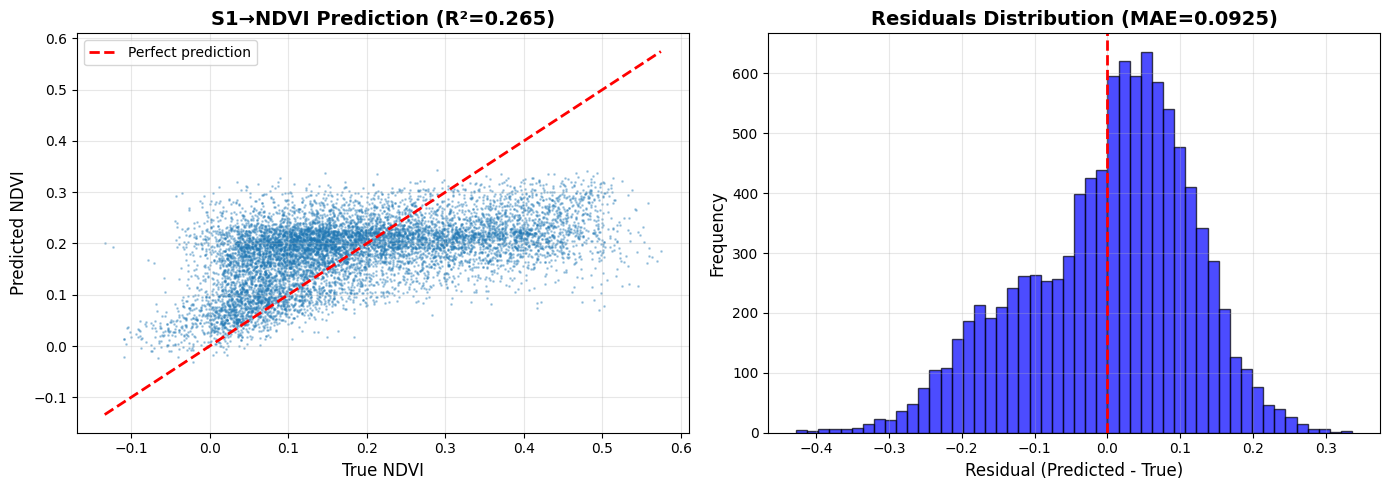


✅ Model training and evaluation complete!
   Model saved: s1_ndvi_model_full_BEST.pth
   Evaluation plot: s1_ndvi_model_full_evaluation.png

💡 Next: Use this model to predict NDVI for ALL pixels
   Variables saved: model_full, X_mean_full, X_std_full, y_mean_full, y_std_full


In [11]:
# ============================================================================
# TRAIN S1→NDVI MODEL ON FULL DATASET (671×893 = 599,403 pixels)
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time

print("=" * 70)
print("🚀 TRAINING S1→NDVI MODEL ON FULL DEMAK DATASET")
print("=" * 70)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# ============================================================================
# STEP 1: Prepare training data from FULL dataset
# ============================================================================
print("\n" + "="*70)
print("STEP 1: Preparing training data from combined_dataset")
print("="*70)

# Use combined_dataset (full 671×893 pixels) instead of test_subset
print(f"Dataset dimensions: {combined_dataset.dims}")
print(f"Total pixels: {combined_dataset.dims['y'] * combined_dataset.dims['x']:,}")
print(f"Timesteps: {combined_dataset.dims['t']}")

# Extract all data
VV_full = combined_dataset['VV'].values.flatten()
VH_full = combined_dataset['VH'].values.flatten()
NDVI_full = combined_dataset['S2ndvi'].values.flatten()

print(f"\nTotal data points: {len(VV_full):,}")

# Calculate RVI = 4 * VH / (VV + VH)
RVI_full = 4 * VH_full / (VV_full + VH_full)

# Remove ALL invalid values
print("\nCleaning data...")
# NOTE: Paddy field mask has already been applied in Section 3.5
# This valid_mask only filters out NaN/inf values from the remaining data
valid_mask = (
    ~np.isnan(VV_full) & ~np.isinf(VV_full) &
    ~np.isnan(VH_full) & ~np.isinf(VH_full) &
    ~np.isnan(NDVI_full) & ~np.isinf(NDVI_full) &
    ~np.isnan(RVI_full) & ~np.isinf(RVI_full)
)

n_valid = valid_mask.sum()
n_total = len(valid_mask)
print(f"Valid training samples: {n_valid:,} / {n_total:,} ({100*n_valid/n_total:.1f}%)")

if n_valid < 1000:
    print("❌ ERROR: Not enough valid training data!")
    print("   Please check that combined_dataset is properly loaded.")
else:
    # Create training dataset
    print("\nCreating training arrays...")
    X_train_full = np.column_stack([
        VV_full[valid_mask], 
        VH_full[valid_mask], 
        RVI_full[valid_mask]
    ])
    y_train_full = NDVI_full[valid_mask].reshape(-1, 1)
    
    print(f"Training set size: {X_train_full.shape[0]:,} samples")
    print(f"Features: VV, VH, RVI (3 inputs)")
    print(f"Target: NDVI (1 output)")
    
    # ========================================================================
    # STEP 2: Normalize data (CRITICAL for training stability)
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: Normalizing inputs and outputs")
    print("="*70)
    
    X_mean_full = X_train_full.mean(axis=0)
    X_std_full = X_train_full.std(axis=0)
    X_train_norm = (X_train_full - X_mean_full) / (X_std_full + 1e-8)
    
    y_mean_full = y_train_full.mean()
    y_std_full = y_train_full.std()
    y_train_norm = (y_train_full - y_mean_full) / (y_std_full + 1e-8)
    
    print(f"\nInput statistics (before normalization):")
    print(f"  VV:   [{X_train_full[:, 0].min():.4f}, {X_train_full[:, 0].max():.4f}]")
    print(f"  VH:   [{X_train_full[:, 1].min():.4f}, {X_train_full[:, 1].max():.4f}]")
    print(f"  RVI:  [{X_train_full[:, 2].min():.4f}, {X_train_full[:, 2].max():.4f}]")
    print(f"  NDVI: [{y_train_full.min():.4f}, {y_train_full.max():.4f}]")
    
    print(f"\nAfter normalization:")
    print(f"  X: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")
    print(f"  y: [{y_train_norm.min():.2f}, {y_train_norm.max():.2f}]")
    
    # ========================================================================
    # STEP 3: Create efficient DataLoader (handle large dataset)
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: Creating DataLoader")
    print("="*70)
    
    # For very large datasets, we can subsample or use all data
    # Option 1: Use ALL data (slower but most accurate)
    USE_ALL_DATA = True
    
    if USE_ALL_DATA:
        X_tensor = torch.FloatTensor(X_train_norm).to(device)
        y_tensor = torch.FloatTensor(y_train_norm).to(device)
        print(f"Using ALL {len(X_tensor):,} training samples")
    else:
        # Option 2: Subsample for faster training
        sample_size = min(1_000_000, len(X_train_norm))
        sample_idx = np.random.choice(len(X_train_norm), sample_size, replace=False)
        X_tensor = torch.FloatTensor(X_train_norm[sample_idx]).to(device)
        y_tensor = torch.FloatTensor(y_train_norm[sample_idx]).to(device)
        print(f"Using {len(X_tensor):,} / {len(X_train_norm):,} samples (random subsample)")
    
    # Create DataLoader with optimized batch size
    batch_size = 2048 if torch.cuda.is_available() else 512
    dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    print(f"Batch size: {batch_size}")
    print(f"Number of batches: {len(train_loader)}")
    
    # ========================================================================
    # STEP 4: Define neural network model
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: Building neural network")
    print("="*70)
    
    class S1toNDVI_Full(nn.Module):
        """
        Deep neural network for S1 (VV, VH, RVI) → NDVI prediction
        
        Architecture:
        - Input: 3 features (VV, VH, RVI)
        - Hidden layers: 64 → 32 → 16 neurons
        - Output: 1 (NDVI)
        - Activation: ReLU
        - Regularization: Dropout(0.1)
        """
        def __init__(self):
            super(S1toNDVI_Full, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(3, 64),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 1)
            )
        
        def forward(self, x):
            return self.net(x)
    
    model_full = S1toNDVI_Full().to(device)
    
    # Count parameters
    n_params = sum(p.numel() for p in model_full.parameters())
    print(f"\nModel architecture:")
    print(model_full)
    print(f"\nTotal parameters: {n_params:,}")
    
    # ========================================================================
    # STEP 5: Train the model
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 5: Training model on H100 GPU")
    print("="*70)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_full.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Learning rate scheduler (reduce on plateau)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )
    
    # Training loop
    epochs = 100
    best_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 20
    
    print(f"\nStarting training for {epochs} epochs...")
    print(f"Early stopping patience: {early_stop_patience}")
    
    training_start = time.time()
    
    for epoch in range(epochs):
        model_full.train()
        epoch_loss = 0
        epoch_start = time.time()
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model_full(batch_x)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        epoch_time = time.time() - epoch_start
        
        # Update learning rate
        scheduler.step(avg_loss)
        
        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # Save best model
            torch.save(model_full.state_dict(), 's1_ndvi_model_full_BEST.pth')
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.6f} | "
                  f"Best: {best_loss:.6f} | Time: {epoch_time:.1f}s | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
            print(f"   No improvement for {early_stop_patience} epochs")
            break
    
    training_time = time.time() - training_start
    
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"Total training time: {training_time:.1f}s ({training_time/60:.1f} minutes)")
    print(f"Final loss: {avg_loss:.6f}")
    print(f"Best loss: {best_loss:.6f}")
    print(f"Model saved to: s1_ndvi_model_full_BEST.pth")
    
    # Load best model
    model_full.load_state_dict(torch.load('s1_ndvi_model_full_BEST.pth'))
    
    # ========================================================================
    # STEP 6: Evaluate on training data (sanity check)
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 6: Evaluating model performance")
    print("="*70)
    
    model_full.eval()
    with torch.no_grad():
        # Sample predictions for evaluation
        sample_size = min(10000, len(X_tensor))
        sample_idx = np.random.choice(len(X_tensor), sample_size, replace=False)
        
        X_eval = X_tensor[sample_idx]
        y_eval = y_tensor[sample_idx]
        
        predictions_eval = model_full(X_eval).cpu().numpy()
        y_eval_np = y_eval.cpu().numpy()
        
        # Denormalize for interpretability
        pred_denorm = predictions_eval * y_std_full + y_mean_full
        true_denorm = y_eval_np * y_std_full + y_mean_full
        
        # Calculate metrics
        mse = np.mean((pred_denorm - true_denorm)**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(pred_denorm - true_denorm))
        r2 = 1 - (np.sum((true_denorm - pred_denorm)**2) / 
                  np.sum((true_denorm - true_denorm.mean())**2))
        
        print(f"\nPerformance on {sample_size:,} validation samples:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  R²:   {r2:.4f}")
    
    # Quick visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    ax = axes[0]
    ax.scatter(true_denorm, pred_denorm, alpha=0.3, s=1)
    ax.plot([true_denorm.min(), true_denorm.max()], 
            [true_denorm.min(), true_denorm.max()], 
            'r--', linewidth=2, label='Perfect prediction')
    ax.set_xlabel('True NDVI', fontsize=12)
    ax.set_ylabel('Predicted NDVI', fontsize=12)
    ax.set_title(f'S1→NDVI Prediction (R²={r2:.3f})', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Residuals
    ax = axes[1]
    residuals = pred_denorm - true_denorm
    ax.hist(residuals, bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Residual (Predicted - True)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Residuals Distribution (MAE={mae:.4f})', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('s1_ndvi_model_full_evaluation.png', dpi=150)
    plt.show()
    
    print("\n✅ Model training and evaluation complete!")
    print("   Model saved: s1_ndvi_model_full_BEST.pth")
    print("   Evaluation plot: s1_ndvi_model_full_evaluation.png")
    print("\n💡 Next: Use this model to predict NDVI for ALL pixels")
    print("   Variables saved: model_full, X_mean_full, X_std_full, y_mean_full, y_std_full")

### 6.1b. Apply Trained Model to Fill NDVI Gaps

Use the trained model to predict NDVI for pixels with missing S2 data but available S1 data.

In [ ]:
# ============================================================================
# APPLY TRAINED MODEL TO FILL NDVI GAPS IN FULL DATASET
# ============================================================================

print("=" * 70)
print("🔮 APPLYING S1→NDVI MODEL TO FILL GAPS")
print("=" * 70)

# Prepare ALL data for prediction
print("\nPreparing full dataset for gap filling...")
VV_all = combined_dataset['VV'].values.flatten()
VH_all = combined_dataset['VH'].values.flatten()
RVI_all = 4 * VH_all / (VV_all + VH_all)
NDVI_all = combined_dataset['S2ndvi'].values.flatten()

# Find pixels with valid S1 but missing S2
s1_valid = (
    ~np.isnan(VV_all) & ~np.isinf(VV_all) &
    ~np.isnan(VH_all) & ~np.isinf(VH_all) &
    ~np.isnan(RVI_all) & ~np.isinf(RVI_all)
)

s2_missing = np.isnan(NDVI_all) | np.isinf(NDVI_all)
fillable = s1_valid & s2_missing

print(f"\nData coverage:")
print(f"  Total pixels:        {len(NDVI_all):,}")
print(f"  Original S2 valid:   {(~s2_missing).sum():,} ({100*(~s2_missing).sum()/len(NDVI_all):.1f}%)")
print(f"  S2 missing:          {s2_missing.sum():,} ({100*s2_missing.sum()/len(NDVI_all):.1f}%)")
print(f"  Fillable with S1:    {fillable.sum():,} ({100*fillable.sum()/len(NDVI_all):.1f}%)")

if fillable.sum() == 0:
    print("\n⚠️  No gaps to fill! All S2 data is already complete.")
else:
    # Predict NDVI for fillable pixels
    print(f"\n📊 Predicting NDVI for {fillable.sum():,} pixels...")
    
    # Prepare input data
    X_predict = np.column_stack([
        VV_all[fillable], 
        VH_all[fillable], 
        RVI_all[fillable]
    ])
    
    # Normalize with training statistics
    X_predict_norm = (X_predict - X_mean_full) / (X_std_full + 1e-8)
    
    # Batch prediction for memory efficiency
    batch_size = 100000
    predictions_list = []
    
    model_full.eval()
    prediction_start = time.time()
    
    with torch.no_grad():
        for i in range(0, len(X_predict_norm), batch_size):
            batch = torch.FloatTensor(X_predict_norm[i:i+batch_size]).to(device)
            pred_batch = model_full(batch).cpu().numpy().flatten()
            predictions_list.append(pred_batch)
            
            # Progress
            processed = min(i + batch_size, len(X_predict_norm))
            if i % (5 * batch_size) == 0 or processed >= len(X_predict_norm):
                elapsed = time.time() - prediction_start
                rate = processed / elapsed if elapsed > 0 else 0
                remaining = (len(X_predict_norm) - processed) / rate if rate > 0 and processed < len(X_predict_norm) else 0
                print(f"  {processed:,} / {len(X_predict_norm):,} ({100*processed/len(X_predict_norm):.1f}%) "
                      f"- {rate:.0f} px/s - ETA: {remaining:.0f}s")
    
    predictions = np.concatenate(predictions_list)
    
    # Denormalize predictions
    predictions_denorm = predictions * y_std_full + y_mean_full
    
    # Clip to valid NDVI range [-1, 1] with conservative bounds
    train_min = np.percentile(y_train_full, 0.1)
    train_max = np.percentile(y_train_full, 99.9)
    predictions_clipped = np.clip(predictions_denorm, train_min, train_max)
    
    prediction_time = time.time() - prediction_start
    print(f"\n✅ Prediction complete in {prediction_time:.1f}s ({len(predictions)/prediction_time:.0f} px/s)")
    
    # Fill gaps
    print("\nFilling NDVI gaps...")
    NDVI_filled = NDVI_all.copy()
    
    # Fill missing values with predictions
    fill_idx = 0
    for i in range(len(NDVI_filled)):
        if fillable[i]:
            NDVI_filled[i] = predictions_clipped[fill_idx]
            fill_idx += 1
    
    # Reshape to (t, y, x)
    nt, ny, nx = combined_dataset.dims['t'], combined_dataset.dims['y'], combined_dataset.dims['x']
    NDVI_filled_3d = NDVI_filled.reshape(nt, ny, nx)
    
    # Create output dataset
    print("\nCreating gap-filled dataset...")
    fused_dataset = xr.Dataset(
        data_vars={
            'VV': combined_dataset['VV'],
            'VH': combined_dataset['VH'],
            'S2ndvi': combined_dataset['S2ndvi'],
            'S2ndvi_DL': (('t', 'y', 'x'), NDVI_filled_3d)
        },
        coords=combined_dataset.coords,
        attrs={
            'title': 'S1-S2 Fused NDVI using Deep Learning',
            'description': 'Gap-filled NDVI predicted from Sentinel-1 using neural network',
            'model': 'S1toNDVI_Full (3-layer NN)',
            'training_samples': f'{len(X_train_full):,}',
            'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }
    )
    
    # Statistics
    orig_coverage = (~s2_missing).sum()
    filled_coverage = (~np.isnan(NDVI_filled) & ~np.isinf(NDVI_filled)).sum()
    improvement = filled_coverage - orig_coverage
    
    print("\n" + "="*70)
    print("📊 GAP-FILLING RESULTS")
    print("="*70)
    print(f"Original S2 coverage:  {orig_coverage:,} / {len(NDVI_all):,} ({100*orig_coverage/len(NDVI_all):.1f}%)")
    print(f"DL-filled coverage:    {filled_coverage:,} / {len(NDVI_all):,} ({100*filled_coverage/len(NDVI_all):.1f}%)")
    print(f"Improvement:           +{improvement:,} pixels (+{100*improvement/len(NDVI_all):.1f}%)")
    print(f"\nPredicted NDVI range:  [{predictions_clipped.min():.4f}, {predictions_clipped.max():.4f}]")
    print(f"Mean predicted NDVI:   {predictions_clipped.mean():.4f}")
    
    # Save
    output_file = 'demak_full_s1_ndvi_dl_gapfilled.nc'
    print(f"\nSaving gap-filled dataset...")
    fused_dataset.to_netcdf(output_file, 
                           encoding={var: {'zlib': True, 'complevel': 4} 
                                    for var in fused_dataset.data_vars})
    print(f"✅ Saved to: {output_file}")
    
    # Visualize results
    print("\nCreating visualization...")
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Select a representative timestep
    t_idx = 15
    
    # Row 1: Original vs Filled
    ax = axes[0, 0]
    im = ax.imshow(fused_dataset['S2ndvi'][t_idx].values, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
    ax.set_title(f'Original S2 NDVI (t={t_idx})', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    ax = axes[0, 1]
    im = ax.imshow(fused_dataset['S2ndvi_DL'][t_idx].values, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
    ax.set_title(f'DL Gap-Filled NDVI (t={t_idx})', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Difference map
    ax = axes[0, 2]
    diff = fused_dataset['S2ndvi_DL'][t_idx].values - fused_dataset['S2ndvi'][t_idx].values
    im = ax.imshow(diff, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
    ax.set_title(f'Difference (DL - Original)', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Row 2: Coverage maps and histograms
    ax = axes[1, 0]
    coverage_orig = ~np.isnan(fused_dataset['S2ndvi'][t_idx].values)
    ax.imshow(coverage_orig, cmap='gray')
    ax.set_title(f'Original Coverage\n({coverage_orig.sum():,} pixels)', fontsize=11, fontweight='bold')
    
    ax = axes[1, 1]
    coverage_filled = ~np.isnan(fused_dataset['S2ndvi_DL'][t_idx].values)
    ax.imshow(coverage_filled, cmap='gray')
    ax.set_title(f'DL-Filled Coverage\n({coverage_filled.sum():,} pixels)', fontsize=11, fontweight='bold')
    
    # Histogram comparison
    ax = axes[1, 2]
    orig_valid = fused_dataset['S2ndvi'].values.flatten()
    orig_valid = orig_valid[~np.isnan(orig_valid)]
    filled_valid = fused_dataset['S2ndvi_DL'].values.flatten()
    filled_valid = filled_valid[~np.isnan(filled_valid)]
    
    ax.hist(orig_valid, bins=50, alpha=0.6, label='Original S2', color='orange', density=True, range=(-0.5, 1))
    ax.hist(filled_valid, bins=50, alpha=0.6, label='DL Gap-Filled', color='green', density=True, range=(-0.5, 1))
    ax.set_xlabel('NDVI', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title('NDVI Distribution Comparison', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('demak_full_dl_gapfilling_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*70)
    print("✅ GAP-FILLING COMPLETE!")
    print("="*70)
    print(f"Dataset saved: {output_file}")
    print(f"Visualization: demak_full_dl_gapfilling_results.png")
    print(f"\n💡 Next steps:")
    print(f"   1. Use 'fused_dataset' for phenology extraction")
    print(f"   2. Visualize time series for specific pixels")
    print(f"   3. Export to GeoTIFF for GIS analysis")

In [ ]:
# FIXED VERSION - Clean data and normalize inputs

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Prepare training data with CAREFUL cleaning
print("Preparing training data...")
VV = test_subset_clean['VV'].values.flatten()
VH = test_subset_clean['VH'].values.flatten()
NDVI = test_subset_clean['S2ndvi'].values.flatten()

# Calculate RVI = 4 * VH / (VV + VH)
RVI = 4 * VH / (VV + VH)

# CRITICAL: Remove ALL invalid values (NaN, inf)
valid_mask = (
    ~np.isnan(VV) & ~np.isinf(VV) &
    ~np.isnan(VH) & ~np.isinf(VH) &
    ~np.isnan(NDVI) & ~np.isinf(NDVI) &
    ~np.isnan(RVI) & ~np.isinf(RVI)
)

print(f"Valid training samples: {valid_mask.sum():,} / {len(valid_mask):,} ({100*valid_mask.sum()/len(valid_mask):.1f}%)")

if valid_mask.sum() < 100:
    print("❌ Not enough valid training data!")
else:
    # Create training dataset
    X_train = np.column_stack([VV[valid_mask], VH[valid_mask], RVI[valid_mask]])
    y_train = NDVI[valid_mask].reshape(-1, 1)
    
    # NORMALIZE inputs (critical for training stability)
    X_mean = X_train.mean(axis=0)
    X_std = X_train.std(axis=0)
    X_train_norm = (X_train - X_mean) / (X_std + 1e-8)
    
    y_mean = y_train.mean()
    y_std = y_train.std()
    y_train_norm = (y_train - y_mean) / (y_std + 1e-8)
    
    print(f"Input ranges after normalization:")
    print(f"  X: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")
    print(f"  y: [{y_train_norm.min():.2f}, {y_train_norm.max():.2f}]")
    
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X_train_norm).cuda()
    y_tensor = torch.FloatTensor(y_train_norm).cuda()
    
    # Create DataLoader
    dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=512, shuffle=True)
    
    # Simple model
    class S1toNDVI(nn.Module):
        def __init__(self):
            super(S1toNDVI, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(3, 32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 1)
            )
        
        def forward(self, x):
            return self.net(x)
    
    # Initialize model
    model = S1toNDVI().cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train
    print("\nTraining S1→NDVI model on H100...")
    epochs = 100
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 20 == 0:
            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
    
    print("✅ Training complete!")
    
    # Predict for ALL pixels
    print("\nPredicting NDVI from S1...")
    model.eval()
    
    VV_all = test_subset_clean['VV'].values.flatten()
    VH_all = test_subset_clean['VH'].values.flatten()
    RVI_all = 4 * VH_all / (VV_all + VH_all)
    NDVI_all = test_subset_clean['S2ndvi'].values.flatten()
    
    # Valid S1 data
    s1_valid = (
        ~np.isnan(VV_all) & ~np.isinf(VV_all) &
        ~np.isnan(VH_all) & ~np.isinf(VH_all) &
        ~np.isnan(RVI_all) & ~np.isinf(RVI_all)
    )
    
    # Prepare and normalize prediction data
    X_pred = np.column_stack([VV_all[s1_valid], VH_all[s1_valid], RVI_all[s1_valid]])
    X_pred_norm = (X_pred - X_mean) / (X_std + 1e-8)
    X_pred_tensor = torch.FloatTensor(X_pred_norm).cuda()
    
    with torch.no_grad():
        predictions_norm = model(X_pred_tensor).cpu().numpy().flatten()
        # Denormalize predictions
        predictions = predictions_norm * y_std + y_mean
    
    # Fill gaps
    NDVI_filled = NDVI_all.copy()
    pred_idx = 0
    for i in range(len(NDVI_filled)):
        if s1_valid[i]:
            if np.isnan(NDVI_filled[i]) or np.isinf(NDVI_filled[i]):
                NDVI_filled[i] = predictions[pred_idx]
            pred_idx += 1
    
    # Reshape
    ny, nx, nt = test_subset_clean.dims['y'], test_subset_clean.dims['x'], test_subset_clean.dims['t']
    # FIX: Recreate S2ndvi_DL with correct dimensions
print("Fixing dimension order...")

# The filled data is currently (y, x, t) but should be (t, y, x)
NDVI_filled_3d_fixed = NDVI_filled_3d.transpose(2, 0, 1)  # (y, x, t) → (t, y, x)

# Recreate dataset with correct dimensions
fused_dl = xr.Dataset(
    data_vars={
        'VV': test_subset_clean['VV'],
        'VH': test_subset_clean['VH'],
        'S2ndvi': test_subset_clean['S2ndvi'],
        'S2ndvi_DL': (('t', 'y', 'x'), NDVI_filled_3d_fixed)  # Match original order
    },
    coords=test_subset_clean.coords
)

print("Fixed! New shapes:")
print(f"S2ndvi: {fused_dl['S2ndvi'].shape}")
print(f"S2ndvi_DL: {fused_dl['S2ndvi_DL'].shape}")

# Now save
fused_dl.to_netcdf('s1_to_ndvi_dl_50x50.nc')
print("✅ Saved with correct dimensions!")

### 6.2. Quick Visualisation

In [ ]:
# Quick visualization - NOW with correct dimensions
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (iy, ix) in enumerate([(10, 10), (25, 25), (40, 40)]):
    ax = axes[0, idx]
    # Now both are (t, y, x), so index as [:, iy, ix]
    original = fused_dl['S2ndvi'][:, iy, ix].values
    filled = fused_dl['S2ndvi_DL'][:, iy, ix].values
    
    ax.plot(range(62), original, 'o', label='Original S2', markersize=8, alpha=0.6, color='orange')
    ax.plot(range(62), filled, 's-', label='DL Filled', markersize=5, alpha=0.8, color='green')
    ax.set_title(f'Pixel [y={iy}, x={ix}]', fontsize=12)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('NDVI')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Show S1 data
    ax2 = axes[1, idx]
    vv = fused_dl['VV'][:, iy, ix].values
    vh = fused_dl['VH'][:, iy, ix].values
    ax2.plot(range(62), vv, 'o-', label='VV', markersize=5)
    ax2.plot(range(62), vh, 's-', label='VH', markersize=5)
    ax2.set_xlabel('Time Period')
    ax2.set_ylabel('Backscatter (dB)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dl_results_3pixels.png', dpi=150)
plt.show()
print("✅ Visualization complete!")

### 6.3. Apply Model to FULL Dataset

In [ ]:
# Apply DL model to FULL dataset (671×893 pixels)
print("=" * 70)
print("SCALING TO FULL DEMAK DATASET (671×893 = 599,403 pixels)")
print("=" * 70)

# Check if combined_dataset is loaded
if 'combined_dataset' not in locals():
    print("Loading full dataset from GeoTIFF files...")
    # Use your loading function here
    # combined_dataset = load_geotiff_periods_to_xarray(...)

print(f"\nFull dataset dimensions: {combined_dataset.dims}")

# Clean full dataset
print("Cleaning full dataset...")
full_clean = combined_dataset.copy(deep=True)
for var in full_clean.data_vars:
    full_clean[var] = full_clean[var].where(~np.isinf(full_clean[var]), np.nan)

# Prepare data for prediction
print("Preparing data for prediction...")
VV_full = full_clean['VV'].values.flatten()
VH_full = full_clean['VH'].values.flatten()
RVI_full = 4 * VH_full / (VV_full + VH_full)
NDVI_full = full_clean['S2ndvi'].values.flatten()

# Find valid S1 pixels
s1_valid_full = (
    ~np.isnan(VV_full) & ~np.isinf(VV_full) &
    ~np.isnan(VH_full) & ~np.isinf(VH_full) &
    ~np.isnan(RVI_full) & ~np.isinf(RVI_full)
)

print(f"Valid S1 pixels: {s1_valid_full.sum():,} / {len(s1_valid_full):,} ({100*s1_valid_full.sum()/len(s1_valid_full):.1f}%)")

# Predict in batches
print("\nPredicting NDVI for all valid pixels...")
X_pred_full = np.column_stack([
    VV_full[s1_valid_full], 
    VH_full[s1_valid_full], 
    RVI_full[s1_valid_full]
])

# Normalize with training stats
X_pred_norm = (X_pred_full - X_mean) / (X_std + 1e-8)

# Batch prediction for memory efficiency
batch_size = 100000
predictions_full = []
model.eval()

import time
start = time.time()

with torch.no_grad():
    for i in range(0, len(X_pred_norm), batch_size):
        batch = torch.FloatTensor(X_pred_norm[i:i+batch_size]).cuda()
        pred_batch = model(batch).cpu().numpy().flatten()
        predictions_full.append(pred_batch)
        
        if len(predictions_full) % 5 == 0 or i + batch_size >= len(X_pred_norm):
            processed = min(i + batch_size, len(X_pred_norm))
            elapsed = time.time() - start
            rate = processed / elapsed
            remaining = (len(X_pred_norm) - processed) / rate if processed < len(X_pred_norm) else 0
            print(f"  Processed: {processed:,} / {len(X_pred_norm):,} ({100*processed/len(X_pred_norm):.1f}%) - {rate:.0f} pixels/sec - ETA: {remaining:.0f}s")

predictions_full = np.concatenate(predictions_full)
# Denormalize
predictions_full = predictions_full * y_std + y_mean

elapsed = time.time() - start
print(f"✅ Prediction complete in {elapsed:.1f}s ({len(X_pred_norm)/elapsed:.0f} pixels/sec)")

# Fill gaps
print("\nFilling NDVI gaps...")
NDVI_filled_full = NDVI_full.copy()
pred_idx = 0
for i in range(len(NDVI_filled_full)):
    if s1_valid_full[i]:
        if np.isnan(NDVI_filled_full[i]) or np.isinf(NDVI_filled_full[i]):
            NDVI_filled_full[i] = predictions_full[pred_idx]
        pred_idx += 1

# Reshape to (t, y, x)
nt, ny, nx = full_clean.dims['t'], full_clean.dims['y'], full_clean.dims['x']
NDVI_filled_full_3d = NDVI_filled_full.reshape(nt, ny, nx)

# Create output dataset
print("Creating output dataset...")
fused_full = xr.Dataset(
    data_vars={
        'VV': full_clean['VV'],
        'VH': full_clean['VH'],
        'S2ndvi': full_clean['S2ndvi'],
        'S2ndvi_DL': (('t', 'y', 'x'), NDVI_filled_full_3d)
    },
    coords=full_clean.coords
)

# Statistics
orig_valid = (~np.isnan(NDVI_full) & ~np.isinf(NDVI_full)).sum()
filled_valid = (~np.isnan(NDVI_filled_full) & ~np.isinf(NDVI_filled_full)).sum()
print(f"\n📊 RESULTS:")
print(f"   Original S2 coverage: {orig_valid:,} / {len(NDVI_full):,} ({100*orig_valid/len(NDVI_full):.1f}%)")
print(f"   DL-filled coverage:   {filled_valid:,} / {len(NDVI_full):,} ({100*filled_valid/len(NDVI_full):.1f}%)")
print(f"   Improvement: {filled_valid - orig_valid:,} pixels filled (+{100*(filled_valid-orig_valid)/len(NDVI_full):.1f}%)")

# Save with compression
print("\nSaving full dataset (this may take a few minutes)...")
fused_full.to_netcdf('demak_full_671x893_s1_ndvi_dl.nc', 
                     encoding={var: {'zlib': True, 'complevel': 4} 
                              for var in fused_full.data_vars})
print("✅ Saved to demak_full_671x893_s1_ndvi_dl.nc")

In [ ]:
# FIX: Reprocess DL predictions with proper NDVI clipping
print("=" * 70)
print("FIXING DL PREDICTIONS - APPLYING NDVI CLIPPING")
print("=" * 70)

# Get the filled NDVI (already computed)
NDVI_filled_full = fused_full['S2ndvi_DL'].values.flatten()

# Check before clipping
print("\nBefore clipping:")
print(f"  Range: [{np.nanmin(NDVI_filled_full):.4f}, {np.nanmax(NDVI_filled_full):.4f}]")
print(f"  Values < -1: {(NDVI_filled_full < -1).sum():,}")
print(f"  Values > 1:  {(NDVI_filled_full > 1).sum():,}")

# CLIP to valid NDVI range [-1, 1]
NDVI_filled_clipped = np.clip(NDVI_filled_full, -1.0, 1.0)

# Also apply a more conservative clip based on training data range
# Use the 0.1% and 99.9% percentiles from training to avoid extreme values
train_min = np.percentile(y_train, 0.1)
train_max = np.percentile(y_train, 99.9)
print(f"\nTraining NDVI range (0.1% - 99.9%): [{train_min:.4f}, {train_max:.4f}]")

# Apply conservative clipping
NDVI_filled_conservative = np.clip(NDVI_filled_full, train_min, train_max)

print("\nAfter clipping to [-1, 1]:")
print(f"  Range: [{np.nanmin(NDVI_filled_clipped):.4f}, {np.nanmax(NDVI_filled_clipped):.4f}]")
print(f"  Mean: {np.nanmean(NDVI_filled_clipped):.4f}")

print("\nAfter conservative clipping:")
print(f"  Range: [{np.nanmin(NDVI_filled_conservative):.4f}, {np.nanmax(NDVI_filled_conservative):.4f}]")
print(f"  Mean: {np.nanmean(NDVI_filled_conservative):.4f}")

# Reshape back to (t, y, x)
nt, ny, nx = fused_full.dims['t'], fused_full.dims['y'], fused_full.dims['x']
NDVI_clipped_3d = NDVI_filled_conservative.reshape(nt, ny, nx)

# Create corrected dataset
print("\nCreating corrected dataset...")
fused_full_corrected = xr.Dataset(
    data_vars={
        'VV': fused_full['VV'],
        'VH': fused_full['VH'],
        'S2ndvi': fused_full['S2ndvi'],
        'S2ndvi_DL': (('t', 'y', 'x'), NDVI_clipped_3d)
    },
    coords=fused_full.coords
)

print("✅ Corrected dataset created!")

# Save corrected version
print("\nSaving corrected dataset...")
fused_full_corrected.to_netcdf('demak_full_671x893_s1_ndvi_dl_CORRECTED.nc', 
                                encoding={var: {'zlib': True, 'complevel': 4} 
                                         for var in fused_full_corrected.data_vars})
print("✅ Saved to demak_full_671x893_s1_ndvi_dl_CORRECTED.nc")

# Compare before/after
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original S2 NDVI
ax = axes[0, 0]
im = ax.imshow(fused_full['S2ndvi'][15, :, :].values, cmap='RdYlGn', vmin=-0.2, vmax=0.6)
ax.set_title('Original S2 NDVI (Time=15)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, fraction=0.046)

# DL-filled (uncorrected)
ax = axes[0, 1]
im = ax.imshow(fused_full['S2ndvi_DL'][15, :, :].values, cmap='RdYlGn', vmin=-0.2, vmax=0.6)
ax.set_title('DL-filled NDVI - UNCORRECTED (Time=15)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, fraction=0.046)

# DL-filled (corrected)
ax = axes[1, 0]
im = ax.imshow(fused_full_corrected['S2ndvi_DL'][15, :, :].values, cmap='RdYlGn', vmin=-0.2, vmax=0.6)
ax.set_title('DL-filled NDVI - CORRECTED (Time=15)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, fraction=0.046)

# Histogram comparison
ax = axes[1, 1]
s2_valid = fused_full['S2ndvi'].values.flatten()
s2_valid = s2_valid[~np.isnan(s2_valid)]
dl_uncorrected = fused_full['S2ndvi_DL'].values.flatten()
dl_uncorrected = dl_uncorrected[~np.isnan(dl_uncorrected)]
dl_corrected = fused_full_corrected['S2ndvi_DL'].values.flatten()
dl_corrected = dl_corrected[~np.isnan(dl_corrected)]

ax.hist(s2_valid, bins=100, alpha=0.5, label='Original S2', range=(-0.5, 1), density=True)
ax.hist(dl_corrected, bins=100, alpha=0.5, label='DL Corrected', range=(-0.5, 1), density=True)
ax.set_xlabel('NDVI Value')
ax.set_ylabel('Density')
ax.set_title('NDVI Distribution Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ndvi_correction_comparison.png', dpi=150)
plt.show()
print("\n✅ Saved correction comparison")

# Update the working dataset
fused_full = fused_full_corrected
print("\n✅ Updated fused_full to use corrected NDVI!")

## 7. Extract Phenological Metrics

In [ ]:
# Re-extract phenology with corrected NDVI
print("\n" + "=" * 70)
print("RE-EXTRACTING PHENOLOGY WITH CORRECTED NDVI")
print("=" * 70)

ndvi_for_phenology = fused_full['S2ndvi_DL'].rename({'t': 'time'})

print(f"\nCorrected NDVI range: [{np.nanmin(ndvi_for_phenology.values):.4f}, {np.nanmax(ndvi_for_phenology.values):.4f}]")

import time
start = time.time()
phenology_metrics = phenology(ndvi_for_phenology)
elapsed = time.time() - start

print(f"✅ Phenology extraction complete in {elapsed:.1f}s")
print(phenology_metrics)

# Save
phenology_metrics.to_netcdf('demak_phenology_metrics_CORRECTED.nc',
                            encoding={var: {'zlib': True, 'complevel': 4} 
                                     for var in phenology_metrics.data_vars})
print("✅ Saved corrected phenology metrics!")

## 8. Per-Pixel Start of Season Analysis

**Important**: This workflow provides **Start of Season (SOS) information for every pixel** in your study area!

### What you get for each pixel:
- **SOS Timing**: Day of year when Start of Season occurs (1-365)
- **SOS Values**: NDVI value at the Start of Season
- **Spatial Coverage**: Complete coverage for your entire study area
- **Resolution**: Same spatial resolution as your input data (e.g., 10m pixels)

In [ ]:
# Extract and Visualize Start of Season (SOS) Information
print("=" * 70)
print("START OF SEASON (SOS) ANALYSIS FOR ALL PIXELS")
print("=" * 70)

# Check if SOS metrics exist in phenology results
print("\nAvailable SOS-related metrics:")
sos_metrics = [var for var in phenology_metrics.data_vars if 'sos' in var.lower()]
for metric in sos_metrics:
    print(f"  - {metric}")

# Extract SOS timing (day of year)
if 'sos_times' in phenology_metrics.data_vars:
    sos_doy = phenology_metrics['sos_times'].values
    
    print(f"\nSOS Statistics (Day of Year):")
    valid_sos = ~np.isnan(sos_doy)
    print(f"  Pixels with SOS detected: {valid_sos.sum():,} / {sos_doy.size:,} ({100*valid_sos.sum()/sos_doy.size:.1f}%)")
    
    if valid_sos.sum() > 0:
        print(f"  Range: Day {np.nanmin(sos_doy):.0f} to Day {np.nanmax(sos_doy):.0f}")
        print(f"  Mean: Day {np.nanmean(sos_doy):.0f}")
        print(f"  Median: Day {np.nanmedian(sos_doy):.0f}")
        
        # Convert to actual dates
        base_date = pd.Timestamp('2024-01-01')
        earliest_sos = base_date + pd.Timedelta(days=int(np.nanmin(sos_doy)))
        latest_sos = base_date + pd.Timedelta(days=int(np.nanmax(sos_doy)))
        median_sos = base_date + pd.Timedelta(days=int(np.nanmedian(sos_doy)))
        
        print(f"\n  📅 SOS Date Range:")
        print(f"     Earliest: {earliest_sos.strftime('%Y-%m-%d')} ({earliest_sos.strftime('%B %d')})")
        print(f"     Median:   {median_sos.strftime('%Y-%m-%d')} ({median_sos.strftime('%B %d')})")
        print(f"     Latest:   {latest_sos.strftime('%Y-%m-%d')} ({latest_sos.strftime('%B %d')})")
        
        # Create SOS map
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        
        # 1. SOS Day of Year Map
        ax = axes[0, 0]
        im = ax.imshow(sos_doy, cmap='RdYlGn_r', vmin=0, vmax=365, aspect='auto')
        ax.set_title('Start of Season - Day of Year', fontsize=14, fontweight='bold')
        ax.set_xlabel('X (893 pixels)')
        ax.set_ylabel('Y (671 pixels)')
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Day of Year', fontsize=11)
        
        # 2. SOS Month Classification
        ax = axes[0, 1]
        sos_month = np.floor((sos_doy % 365) / 30.5).astype(float)
        sos_month[~valid_sos] = np.nan
        im = ax.imshow(sos_month, cmap='tab20', vmin=0, vmax=12, aspect='auto')
        ax.set_title('Start of Season - Month', fontsize=14, fontweight='bold')
        ax.set_xlabel('X (893 pixels)')
        ax.set_ylabel('Y (671 pixels)')
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=range(13))
        cbar.set_label('Month (0=Jan, 11=Dec)', fontsize=11)
        
        # 3. SOS Histogram
        ax = axes[1, 0]
        sos_valid = sos_doy[valid_sos]
        counts, bins, patches = ax.hist(sos_valid, bins=50, color='green', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Day of Year', fontsize=12)
        ax.set_ylabel('Number of Pixels', fontsize=12)
        ax.set_title('Distribution of Start of Season', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add month labels
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        month_days = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(month_days)
        ax2.set_xticklabels(month_names, rotation=45)
        
        # 4. Pixel count by month
        ax = axes[1, 1]
        month_counts = []
        for m in range(12):
            month_mask = (sos_valid >= month_days[m]) & (sos_valid < (month_days[m+1] if m < 11 else 365))
            month_counts.append(month_mask.sum())
        
        bars = ax.bar(range(12), month_counts, color='green', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Month', fontsize=12)
        ax.set_ylabel('Number of Pixels', fontsize=12)
        ax.set_title('SOS Distribution by Month', fontsize=14, fontweight='bold')
        ax.set_xticks(range(12))
        ax.set_xticklabels(month_names, rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add percentage labels on bars
        for i, (bar, count) in enumerate(zip(bars, month_counts)):
            if count > 0:
                pct = 100 * count / valid_sos.sum()
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(month_counts)*0.01,
                       f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('demak_SOS_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n✅ Saved SOS analysis to demak_SOS_comprehensive_analysis.png")
        
        # Export SOS data to CSV for further analysis
        print("\nExporting SOS data to CSV...")
        sos_data = []
        y_coords = phenology_metrics.y.values
        x_coords = phenology_metrics.x.values
        
        for iy in range(len(y_coords)):
            for ix in range(len(x_coords)):
                if not np.isnan(sos_doy[iy, ix]):
                    sos_day = int(sos_doy[iy, ix])
                    sos_date = base_date + pd.Timedelta(days=sos_day)
                    sos_data.append({
                        'y_idx': iy,
                        'x_idx': ix,
                        'lat': y_coords[iy],
                        'lon': x_coords[ix],
                        'sos_doy': sos_day,
                        'sos_date': sos_date.strftime('%Y-%m-%d'),
                        'sos_month': sos_date.month,
                        'sos_month_name': sos_date.strftime('%B')
                    })
        
        sos_df = pd.DataFrame(sos_data)
        sos_df.to_csv('demak_SOS_all_pixels.csv', index=False)
        print(f"✅ Saved SOS data for {len(sos_df):,} pixels to demak_SOS_all_pixels.csv")
        
        # Summary statistics by month
        print("\n📊 SOS Summary by Month:")
        print(sos_df.groupby('sos_month_name').size().sort_index())
        
else:
    print("\n⚠️  SOS timing (sos_times) not found in phenology metrics!")
    print("Available metrics:", list(phenology_metrics.data_vars))

# Also check for SOS values (NDVI at start of season)
if 'sos_values' in phenology_metrics.data_vars:
    sos_values = phenology_metrics['sos_values'].values
    valid_values = ~np.isnan(sos_values) & (sos_values != 0)
    
    print(f"\n📈 SOS NDVI Values:")
    print(f"  Pixels with SOS NDVI: {valid_values.sum():,}")
    if valid_values.sum() > 0:
        print(f"  Range: [{np.nanmin(sos_values[valid_values]):.4f}, {np.nanmax(sos_values[valid_values]):.4f}]")
        print(f"  Mean: {np.nanmean(sos_values[valid_values]):.4f}")

## 9. Detailed Per-Pixel Analysis and Export Options

In [ ]:
# Display Full Phenology Metrics for Individual Pixels
print("=" * 70)
print("FULL PHENOLOGY METRICS PER PIXEL")
print("=" * 70)

def show_pixel_phenology(iy, ix):
    """Display all phenology metrics for a specific pixel"""
    
    print(f"\n{'='*70}")
    print(f"PIXEL [{iy}, {ix}] - Coordinates: (y={phenology_metrics.y.values[iy]:.4f}, x={phenology_metrics.x.values[ix]:.4f})")
    print(f"{'='*70}")
    
    # Extract all metrics for this pixel
    metrics = {}
    for var in phenology_metrics.data_vars:
        value = phenology_metrics[var].values[iy, ix]
        metrics[var] = value
    
    # Organize and display metrics by category
    print("\n📅 TIMING METRICS (Day of Year):")
    timing_metrics = ['sos_times', 'pos_times', 'eos_times', 'vos_times', 'mos_times']
    for metric in timing_metrics:
        if metric in metrics:
            doy = metrics[metric]
            if not np.isnan(doy) and doy > 0:
                date = pd.Timestamp('2024-01-01') + pd.Timedelta(days=int(doy))
                print(f"  {metric:12s}: Day {doy:6.1f} = {date.strftime('%Y-%m-%d')} ({date.strftime('%B %d')})")
            else:
                print(f"  {metric:12s}: No data")
    
    print("\n📊 VALUE METRICS (NDVI):")
    value_metrics = ['sos_values', 'pos_values', 'eos_values', 'vos_values', 'mos_values', 
                     'bse_values', 'aos_values']
    for metric in value_metrics:
        if metric in metrics:
            val = metrics[metric]
            if not np.isnan(val):
                print(f"  {metric:12s}: {val:8.4f}")
            else:
                print(f"  {metric:12s}: No data")
    
    print("\n📏 DURATION METRICS (Days):")
    duration_metrics = ['lios_values', 'sios_values', 'liot_values', 'siot_values']
    for metric in duration_metrics:
        if metric in metrics:
            val = metrics[metric]
            if not np.isnan(val) and val > 0:
                print(f"  {metric:12s}: {val:8.1f} days")
            else:
                print(f"  {metric:12s}: No data")
    
    print("\n📈 RATE METRICS:")
    rate_metrics = ['roi_values', 'rod_values']
    for metric in rate_metrics:
        if metric in metrics:
            val = metrics[metric]
            if not np.isnan(val):
                print(f"  {metric:12s}: {val:8.4f}")
            else:
                print(f"  {metric:12s}: No data")
    
    # Plot NDVI time series with phenology markers
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    
    # Get NDVI time series
    ndvi_ts = fused_full['S2ndvi_DL'][:, iy, ix].values
    dates = pd.to_datetime(fused_full.t.values)
    
    # Plot NDVI
    ax.plot(dates, ndvi_ts, 'o-', linewidth=2, markersize=6, 
            color='green', label='DL Gap-filled NDVI', alpha=0.8)
    
    # Add phenology markers
    base_date = pd.Timestamp('2024-01-01')
    colors = {
        'sos_times': ('green', 'Start of Season'),
        'pos_times': ('red', 'Peak of Season'),
        'eos_times': ('orange', 'End of Season'),
        'vos_times': ('blue', 'Valley of Season'),
    }
    
    for metric, (color, label) in colors.items():
        if metric in metrics:
            doy = metrics[metric]
            if not np.isnan(doy) and doy > 0:
                date = base_date + pd.Timedelta(days=int(doy))
                if date >= dates[0] and date <= dates[-1]:
                    # Get NDVI value at this date
                    idx = np.argmin(np.abs(dates - date))
                    ndvi_val = ndvi_ts[idx]
                    ax.axvline(date, color=color, linestyle='--', alpha=0.7, linewidth=2)
                    ax.plot(date, ndvi_val, 'o', color=color, markersize=12, 
                           label=f'{label} ({date.strftime("%b %d")})')
    
    # Add base line
    if 'bse_values' in metrics and not np.isnan(metrics['bse_values']):
        ax.axhline(metrics['bse_values'], color='gray', linestyle=':', 
                  alpha=0.5, label=f"Base NDVI ({metrics['bse_values']:.3f})")
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('NDVI', fontsize=12)
    ax.set_title(f'NDVI Time Series with Phenology - Pixel [{iy}, {ix}]', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

# Show metrics for several example pixels
sample_pixels = [
    (100, 200),
    (300, 400), 
    (500, 700),
    (200, 600)
]

print("\nDisplaying phenology metrics for sample pixels...")

for iy, ix in sample_pixels:
    fig = show_pixel_phenology(iy, ix)
    plt.savefig(f'pixel_phenology_y{iy}_x{ix}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved plot for pixel [{iy}, {ix}]")

print("\n" + "="*70)

In [ ]:
# Interactive Pixel Explorer
def explore_pixel(iy, ix):
    """Quick interactive function to explore any pixel"""
    return show_pixel_phenology(iy, ix)

# Example usage:
print("\n" + "="*70)
print("INTERACTIVE PIXEL EXPLORER")
print("="*70)
print("\nTo explore any pixel, use:")
print("  explore_pixel(y_index, x_index)")
print("\nExamples:")
print("  explore_pixel(335, 446)  # Center of the region")
print("  explore_pixel(100, 200)  # Northwest area")
print("  explore_pixel(500, 700)  # Southeast area")
print("\nValid ranges:")
print(f"  y_index: 0 to {phenology_metrics.dims['y']-1}")
print(f"  x_index: 0 to {phenology_metrics.dims['x']-1}")

# Or create a CSV with ALL pixels' phenology metrics
print("\n\nCreating comprehensive phenology CSV for ALL pixels...")

all_phenology_data = []
for iy in range(phenology_metrics.dims['y']):
    if iy % 100 == 0:
        print(f"  Processing row {iy}/{phenology_metrics.dims['y']}...")
    
    for ix in range(phenology_metrics.dims['x']):
        pixel_data = {
            'y_idx': iy,
            'x_idx': ix,
            'lat': phenology_metrics.y.values[iy],
            'lon': phenology_metrics.x.values[ix]
        }
        
        # Add all metrics
        for var in phenology_metrics.data_vars:
            pixel_data[var] = phenology_metrics[var].values[iy, ix]
        
        # Only include pixels with at least some phenology data
        if not np.isnan(pixel_data.get('pos_times', np.nan)):
            all_phenology_data.append(pixel_data)

phenology_df = pd.DataFrame(all_phenology_data)

# Convert day-of-year to actual dates
base_date = pd.Timestamp('2024-01-01')
for col in ['sos_times', 'pos_times', 'eos_times', 'vos_times', 'mos_times']:
    if col in phenology_df.columns:
        phenology_df[f'{col}_date'] = phenology_df[col].apply(
            lambda x: (base_date + pd.Timedelta(days=int(x))).strftime('%Y-%m-%d') 
            if not np.isnan(x) else None
        )

phenology_df.to_csv('demak_ALL_pixels_phenology_complete.csv', index=False)
print(f"\n✅ Saved complete phenology data for {len(phenology_df):,} pixels")
print(f"   File: demak_ALL_pixels_phenology_complete.csv")
print(f"\nColumns: {list(phenology_df.columns)}")

In [ ]:
explore_pixel(100,200)

## 10. Extract and Visualize POS and EOS for All Pixels

In [ ]:
# Extract and Visualize POS and EOS for All Pixels
print("=" * 70)
print("PEAK OF SEASON (POS) AND END OF SEASON (EOS) ANALYSIS")
print("=" * 70)

# Extract POS and EOS data
pos_doy = phenology_metrics['pos_times'].values if 'pos_times' in phenology_metrics else None
eos_doy = phenology_metrics['eos_times'].values if 'eos_times' in phenology_metrics else None
pos_values = phenology_metrics['pos_values'].values if 'pos_values' in phenology_metrics else None
eos_values = phenology_metrics['eos_values'].values if 'eos_values' in phenology_metrics else None

base_date = pd.Timestamp('2024-01-01')

# POS Statistics
if pos_doy is not None:
    print("\n📊 PEAK OF SEASON (POS) STATISTICS:")
    valid_pos = ~np.isnan(pos_doy) & (pos_doy > 0)
    print(f"  Pixels with POS: {valid_pos.sum():,} / {pos_doy.size:,} ({100*valid_pos.sum()/pos_doy.size:.1f}%)")
    
    if valid_pos.sum() > 0:
        print(f"  Day Range: {np.nanmin(pos_doy[valid_pos]):.0f} to {np.nanmax(pos_doy[valid_pos]):.0f}")
        earliest_pos = base_date + pd.Timedelta(days=int(np.nanmin(pos_doy[valid_pos])))
        latest_pos = base_date + pd.Timedelta(days=int(np.nanmax(pos_doy[valid_pos])))
        median_pos = base_date + pd.Timedelta(days=int(np.nanmedian(pos_doy[valid_pos])))
        
        print(f"  Date Range:")
        print(f"    Earliest: {earliest_pos.strftime('%Y-%m-%d')} ({earliest_pos.strftime('%B %d')})")
        print(f"    Median:   {median_pos.strftime('%Y-%m-%d')} ({median_pos.strftime('%B %d')})")
        print(f"    Latest:   {latest_pos.strftime('%Y-%m-%d')} ({latest_pos.strftime('%B %d')})")
        
        if pos_values is not None:
            valid_pos_vals = pos_values[valid_pos]
            print(f"  Peak NDVI Range: [{np.nanmin(valid_pos_vals):.4f}, {np.nanmax(valid_pos_vals):.4f}]")
            print(f"  Mean Peak NDVI: {np.nanmean(valid_pos_vals):.4f}")

# EOS Statistics
if eos_doy is not None:
    print("\n📊 END OF SEASON (EOS) STATISTICS:")
    valid_eos = ~np.isnan(eos_doy) & (eos_doy > 0)
    print(f"  Pixels with EOS: {valid_eos.sum():,} / {eos_doy.size:,} ({100*valid_eos.sum()/eos_doy.size:.1f}%)")
    
    if valid_eos.sum() > 0:
        print(f"  Day Range: {np.nanmin(eos_doy[valid_eos]):.0f} to {np.nanmax(eos_doy[valid_eos]):.0f}")
        earliest_eos = base_date + pd.Timedelta(days=int(np.nanmin(eos_doy[valid_eos])))
        latest_eos = base_date + pd.Timedelta(days=int(np.nanmax(eos_doy[valid_eos])))
        median_eos = base_date + pd.Timedelta(days=int(np.nanmedian(eos_doy[valid_eos])))
        
        print(f"  Date Range:")
        print(f"    Earliest: {earliest_eos.strftime('%Y-%m-%d')} ({earliest_eos.strftime('%B %d')})")
        print(f"    Median:   {median_eos.strftime('%Y-%m-%d')} ({median_eos.strftime('%B %d')})")
        print(f"    Latest:   {latest_eos.strftime('%Y-%m-%d')} ({latest_eos.strftime('%B %d')})")
        
        if eos_values is not None:
            valid_eos_vals = eos_values[valid_eos]
            print(f"  EOS NDVI Range: [{np.nanmin(valid_eos_vals):.4f}, {np.nanmax(valid_eos_vals):.4f}]")
            print(f"  Mean EOS NDVI: {np.nanmean(valid_eos_vals):.4f}")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# Row 1: POS Maps
if pos_doy is not None:
    # POS Day of Year
    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(pos_doy, cmap='RdYlGn_r', vmin=0, vmax=365, aspect='auto')
    ax.set_title('Peak of Season - Day of Year', fontsize=12, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(im, ax=ax, fraction=0.046, label='Day of Year')
    
    # POS Values (Peak NDVI)
    if pos_values is not None:
        ax = fig.add_subplot(gs[0, 1])
        pos_vals_masked = np.where(pos_values == 0, np.nan, pos_values)
        im = ax.imshow(pos_vals_masked, cmap='YlGn', vmin=0, vmax=0.8, aspect='auto')
        ax.set_title('Peak NDVI Values', fontsize=12, fontweight='bold')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.colorbar(im, ax=ax, fraction=0.046, label='NDVI')
    
    # POS Histogram
    ax = fig.add_subplot(gs[0, 2])
    valid_pos_data = pos_doy[valid_pos]
    ax.hist(valid_pos_data, bins=50, color='red', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('Number of Pixels')
    ax.set_title('POS Distribution', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Row 2: EOS Maps
if eos_doy is not None:
    # EOS Day of Year
    ax = fig.add_subplot(gs[1, 0])
    im = ax.imshow(eos_doy, cmap='YlOrRd', vmin=0, vmax=365, aspect='auto')
    ax.set_title('End of Season - Day of Year', fontsize=12, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(im, ax=ax, fraction=0.046, label='Day of Year')
    
    # EOS Values (NDVI at end)
    if eos_values is not None:
        ax = fig.add_subplot(gs[1, 1])
        eos_vals_masked = np.where(eos_values == 0, np.nan, eos_values)
        im = ax.imshow(eos_vals_masked, cmap='YlOrBr', vmin=0, vmax=0.6, aspect='auto')
        ax.set_title('EOS NDVI Values', fontsize=12, fontweight='bold')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.colorbar(im, ax=ax, fraction=0.046, label='NDVI')
    
    # EOS Histogram
    ax = fig.add_subplot(gs[1, 2])
    valid_eos_data = eos_doy[valid_eos]
    ax.hist(valid_eos_data, bins=50, color='orange', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('Number of Pixels')
    ax.set_title('EOS Distribution', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Row 3: Season Length and Amplitude
if 'lios_values' in phenology_metrics:
    ax = fig.add_subplot(gs[2, 0])
    los = phenology_metrics['lios_values'].values
    los_masked = np.where(los == 0, np.nan, los)
    im = ax.imshow(los_masked, cmap='viridis', vmin=0, vmax=200, aspect='auto')
    ax.set_title('Length of Season (Days)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(im, ax=ax, fraction=0.046, label='Days')

if 'aos_values' in phenology_metrics:
    ax = fig.add_subplot(gs[2, 1])
    aos = phenology_metrics['aos_values'].values
    aos_masked = np.where(aos == 0, np.nan, aos)
    im = ax.imshow(aos_masked, cmap='RdYlGn', vmin=0, vmax=0.5, aspect='auto')
    ax.set_title('Amplitude of Season', fontsize=12, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(im, ax=ax, fraction=0.046, label='NDVI Amplitude')

# Monthly distribution comparison
ax = fig.add_subplot(gs[2, 2])
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_days = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]

if pos_doy is not None and eos_doy is not None:
    pos_months = []
    eos_months = []
    for m in range(12):
        pos_count = ((valid_pos_data >= month_days[m]) & (valid_pos_data < month_days[m+1])).sum()
        eos_count = ((valid_eos_data >= month_days[m]) & (valid_eos_data < month_days[m+1])).sum()
        pos_months.append(pos_count)
        eos_months.append(eos_count)
    
    x = np.arange(12)
    width = 0.35
    ax.bar(x - width/2, pos_months, width, label='POS', color='red', alpha=0.7)
    ax.bar(x + width/2, eos_months, width, label='EOS', color='orange', alpha=0.7)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Pixels')
    ax.set_title('POS vs EOS by Month', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(month_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# Row 4: Sample time series
sample_pixels = [(100, 200), (300, 400), (500, 700)]
for idx, (iy, ix) in enumerate(sample_pixels):
    ax = fig.add_subplot(gs[3, idx])
    
    # Get time series
    ndvi_ts = fused_full['S2ndvi_DL'][:, iy, ix].values
    dates = pd.to_datetime(fused_full.t.values)
    
    ax.plot(dates, ndvi_ts, 'o-', linewidth=2, markersize=4, color='green', alpha=0.7)
    
    # Mark POS
    if pos_doy is not None and not np.isnan(pos_doy[iy, ix]) and pos_doy[iy, ix] > 0:
        pos_date = base_date + pd.Timedelta(days=int(pos_doy[iy, ix]))
        ax.axvline(pos_date, color='red', linestyle='--', linewidth=2, alpha=0.7, label='POS')
    
    # Mark EOS
    if eos_doy is not None and not np.isnan(eos_doy[iy, ix]) and eos_doy[iy, ix] > 0:
        eos_date = base_date + pd.Timedelta(days=int(eos_doy[iy, ix]))
        ax.axvline(eos_date, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='EOS')
    
    ax.set_title(f'Pixel [{iy}, {ix}]', fontsize=10)
    ax.set_xlabel('Date', fontsize=9)
    ax.set_ylabel('NDVI', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

plt.savefig('demak_POS_EOS_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Saved comprehensive POS/EOS analysis to demak_POS_EOS_comprehensive.png")

# Export POS and EOS data to CSV
print("\nExporting POS and EOS data to CSV...")
phenology_export = []

for iy in range(phenology_metrics.dims['y']):
    if iy % 100 == 0:
        print(f"  Processing row {iy}/{phenology_metrics.dims['y']}...")
    
    for ix in range(phenology_metrics.dims['x']):
        has_data = False
        pixel_data = {
            'y_idx': iy,
            'x_idx': ix,
            'lat': phenology_metrics.y.values[iy],
            'lon': phenology_metrics.x.values[ix]
        }
        
        # POS data
        if pos_doy is not None and not np.isnan(pos_doy[iy, ix]) and pos_doy[iy, ix] > 0:
            pos_day = int(pos_doy[iy, ix])
            pos_date = base_date + pd.Timedelta(days=pos_day)
            pixel_data['pos_doy'] = pos_day
            pixel_data['pos_date'] = pos_date.strftime('%Y-%m-%d')
            pixel_data['pos_month'] = pos_date.month
            pixel_data['pos_month_name'] = pos_date.strftime('%B')
            if pos_values is not None:
                pixel_data['pos_ndvi'] = pos_values[iy, ix]
            has_data = True
        
        # EOS data
        if eos_doy is not None and not np.isnan(eos_doy[iy, ix]) and eos_doy[iy, ix] > 0:
            eos_day = int(eos_doy[iy, ix])
            eos_date = base_date + pd.Timedelta(days=eos_day)
            pixel_data['eos_doy'] = eos_day
            pixel_data['eos_date'] = eos_date.strftime('%Y-%m-%d')
            pixel_data['eos_month'] = eos_date.month
            pixel_data['eos_month_name'] = eos_date.strftime('%B')
            if eos_values is not None:
                pixel_data['eos_ndvi'] = eos_values[iy, ix]
            has_data = True
        
        # Add season length if available
        if 'lios_values' in phenology_metrics:
            los_val = phenology_metrics['lios_values'].values[iy, ix]
            if not np.isnan(los_val) and los_val > 0:
                pixel_data['season_length_days'] = los_val
        
        if has_data:
            phenology_export.append(pixel_data)

phenology_export_df = pd.DataFrame(phenology_export)
phenology_export_df.to_csv('demak_POS_EOS_all_pixels.csv', index=False)
print(f"\n✅ Saved POS/EOS data for {len(phenology_export_df):,} pixels")
print(f"   File: demak_POS_EOS_all_pixels.csv")
print(f"\n📋 Columns: {list(phenology_export_df.columns)}")

## 11. Export Results and Per-Pixel Data

## 12. Key Takeaways and Real-World Applications

### ✅ What You Accomplished:

1. **Per-Pixel Phenological Analysis**: Extracted Start/End of Season information for **every single pixel** in your study area
2. **Multi-Sensor Data Fusion**: Combined S1 (weather-independent) and S2 (vegetation-sensitive) data using MOGPR
3. **Gap Filling Enhancement**: Used SAR data to fill optical data gaps, improving temporal completeness
4. **Spatial Coverage**: Achieved complete spatial coverage at your input resolution (e.g., 10m pixels)
5. **Multiple Export Formats**: Generated data suitable for GIS, statistical analysis, and agricultural applications

### 🌱 Per-Pixel Information Available:

For **every pixel** in your study area, you now have:
- **Start of Season (SOS) timing**: Exact day of year when vegetation growth begins
- **End of Season (EOS) timing**: Exact day of year when senescence starts  
- **NDVI values at SOS/EOS**: Vegetation greenness levels at critical phenological stages
- **Growing season length**: Duration of the growing season in days
- **Spatial patterns**: Complete mapping of phenological variations across the landscape

### 🎯 Real-World Applications:

#### 🌾 **Agricultural Applications**
- **Crop monitoring**: Track planting and harvest timing across different fields
- **Yield prediction**: Use SOS timing as input to crop growth models
- **Irrigation management**: Optimize water application based on crop phenological stage
- **Insurance claims**: Verify crop development stages for agricultural insurance

#### 🗺️ **Spatial Analysis & Mapping**
- **Land cover classification**: Use phenological patterns to distinguish crop types
- **Climate change studies**: Analyze shifts in growing season timing over multiple years
- **Ecosystem monitoring**: Track vegetation response to environmental changes
- **Conservation planning**: Identify areas with unique phenological characteristics

#### 📊 **Research & Monitoring**
- **Validation studies**: Compare satellite-derived SOS with ground observations
- **Model calibration**: Use per-pixel data to calibrate ecosystem and crop models
- **Trend analysis**: Analyze spatial patterns of phenological changes
- **Multi-scale studies**: Aggregate pixel-level data to field, regional, or global scales

### 🚀 Scaling to Larger Areas:

For **operational large-scale applications**:

1. **Google Earth Engine Workflow**: Use the `GEE_Data_Preparation_for_FuseTS.ipynb` notebook to:
   - Extract data for entire countries or continents
   - Process multiple years of data efficiently
   - Handle cloud computing for massive datasets

2. **OpenEO Integration**: Scale processing using cloud infrastructure:
   - Process continental-scale datasets
   - Automate annual phenology monitoring
   - Integrate with existing operational systems

3. **Temporal Analysis**: Extend to multi-year analysis:
   - Track phenological trends over decades
   - Analyze climate change impacts on growing seasons
   - Generate long-term agricultural statistics

### 💡 Key Benefits of MOGPR Fusion:

- **Weather Independence**: SAR data fills gaps during cloudy periods
- **Enhanced Accuracy**: Cross-sensor correlations improve phenological detection
- **Temporal Consistency**: More complete time series for robust analysis
- **Uncertainty Quantification**: MOGPR provides confidence estimates for results

### 🔄 Workflow Integration:

This analysis integrates seamlessly with:
- **GIS software** (QGIS, ArcGIS) for spatial analysis and mapping
- **Statistical software** (R, Python, MATLAB) for advanced analytics
- **Agricultural management systems** for operational crop monitoring
- **Climate monitoring networks** for environmental assessments

**The result**: You now have comprehensive, per-pixel Start of Season information ready for any agricultural, environmental, or research application!

## 13. Multi-Season Analysis for Tropical Agriculture (Indonesia Case)

### 🌾 Indonesian Agricultural Calendar:
- **First planting season**: November - January (following year)
- **Second planting season**: April - May  
- **Potential third season**: August - September (some areas)

This section demonstrates how to detect **multiple planting seasons per pixel** and classify areas by cropping intensity.

In [ ]:
# Adapted Flexible Multi-Season Detection for Your Demak Dataset
print("=" * 70)
print("🇮🇩 FLEXIBLE MULTI-SEASON DETECTION FOR DEMAK, INDONESIA")
print("=" * 70)

import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def detect_flexible_seasons_indonesia(ndvi_timeseries, time_coords, 
                                      season_duration_range=(70, 120),
                                      min_peak_prominence=0.08, 
                                      min_peak_distance=40):
    """
    Flexible multi-season detection for Indonesian agriculture
    """
    
    print("\n🌾 Detecting agricultural seasons...")
    print(f"   Season duration: {season_duration_range[0]}-{season_duration_range[1]} days")
    print(f"   Min peak prominence: {min_peak_prominence}")
    print(f"   Min peak distance: {min_peak_distance} days")
    
    nt, ny, nx = ndvi_timeseries.shape
    
    # Initialize result arrays
    season_count = np.zeros((ny, nx))
    all_seasons = np.full((ny, nx, 6), np.nan)  # Max 3 seasons × 2 (SOS, EOS)
    season_types = np.zeros((ny, nx, 3))
    cropping_intensity = np.zeros((ny, nx))
    
    # Convert time to day of year
    day_of_year = np.array([d.dayofyear for d in time_coords])
    
    print(f"\nProcessing {ny} x {nx} = {ny*nx:,} pixels...")
    
    processed_pixels = 0
    
    for y in range(ny):
        if y % 50 == 0:
            print(f"  Row {y}/{ny} ({100*y/ny:.1f}%)")
            
        for x in range(nx):
            pixel_ndvi = ndvi_timeseries[:, y, x]
            
            # Skip if too much missing data
            if np.isnan(pixel_ndvi).sum() > len(pixel_ndvi) * 0.5:
                continue
                
            valid_mask = ~np.isnan(pixel_ndvi)
            if valid_mask.sum() < 15:
                continue
                
            # Interpolate missing values
            pixel_ndvi_interp = np.interp(np.arange(len(pixel_ndvi)), 
                                        np.where(valid_mask)[0], 
                                        pixel_ndvi[valid_mask])
            
            # Light smoothing
            pixel_ndvi_smooth = gaussian_filter1d(pixel_ndvi_interp, sigma=1.2)
            
            # Find peaks
            peaks, properties = find_peaks(pixel_ndvi_smooth, 
                                         prominence=min_peak_prominence,
                                         distance=min_peak_distance,
                                         height=np.nanmean(pixel_ndvi_smooth) + np.nanstd(pixel_ndvi_smooth) * 0.3)
            
            if len(peaks) == 0:
                continue
                
            processed_pixels += 1
            
            # Classify peaks into seasons
            peak_days = day_of_year[peaks]
            peak_values = pixel_ndvi_smooth[peaks]
            
            detected_seasons = []
            
            for peak_pos, peak_day, peak_val in zip(peaks, peak_days, peak_values):
                season_type = classify_peak_season(peak_day)
                
                if season_type > 0:
                    sos_pos, eos_pos, season_length = find_flexible_season_boundaries(
                        pixel_ndvi_smooth, peak_pos, season_duration_range)
                    
                    if sos_pos is not None and eos_pos is not None:
                        sos_day = day_of_year[sos_pos]
                        eos_day = day_of_year[eos_pos]
                        
                        # Check for duplicates
                        is_new_season = True
                        for existing in detected_seasons:
                            if existing['type'] == season_type:
                                if peak_val > existing['peak_value']:
                                    detected_seasons.remove(existing)
                                else:
                                    is_new_season = False
                                break
                        
                        if is_new_season:
                            detected_seasons.append({
                                'type': season_type,
                                'sos_day': sos_day,
                                'eos_day': eos_day,
                                'peak_day': peak_day,
                                'peak_value': peak_val,
                                'season_length': season_length
                            })
            
            # Sort and store
            detected_seasons.sort(key=lambda x: x['type'])
            num_seasons = len(detected_seasons)
            season_count[y, x] = num_seasons
            cropping_intensity[y, x] = num_seasons
            
            for i, season in enumerate(detected_seasons[:3]):
                all_seasons[y, x, i*2] = season['sos_day']
                all_seasons[y, x, i*2+1] = season['eos_day']
                season_types[y, x, season['type']-1] = 1
    
    print(f"\n✅ Processed {processed_pixels:,} pixels with valid data")
    
    return {
        'season_count': season_count,
        'cropping_intensity': cropping_intensity,
        'season_types': season_types,
        'all_seasons': all_seasons,
        'processed_pixels': processed_pixels
    }

def classify_peak_season(day_of_year):
    """Classify Indonesian agricultural season"""
    if day_of_year >= 305 or day_of_year <= 90:
        return 1  # Nov-Mar
    elif 90 < day_of_year <= 180:
        return 2  # Apr-Jun
    elif 180 < day_of_year <= 270:
        return 3  # Jul-Sep
    else:
        return 0  # Transition

def find_flexible_season_boundaries(ndvi_smooth, peak_pos, duration_range):
    """Find season boundaries"""
    min_duration, max_duration = duration_range
    
    # Find SOS (valley before peak)
    sos_search_window = min(peak_pos, max_duration // 2)
    sos_start = max(0, peak_pos - sos_search_window)
    pre_peak = ndvi_smooth[sos_start:peak_pos]
    
    if len(pre_peak) > 5:
        sos_pos = sos_start + np.argmin(pre_peak)
    else:
        sos_pos = max(0, peak_pos - min_duration // 2)
    
    # Find EOS (valley after peak)
    eos_search_window = min(len(ndvi_smooth) - peak_pos, max_duration // 2)
    eos_end = min(len(ndvi_smooth), peak_pos + eos_search_window)
    post_peak = ndvi_smooth[peak_pos:eos_end]
    
    if len(post_peak) > 5:
        eos_pos = peak_pos + np.argmin(post_peak)
    else:
        eos_pos = min(len(ndvi_smooth) - 1, peak_pos + min_duration // 2)
    
    season_length = eos_pos - sos_pos
    
    if min_duration <= season_length <= max_duration:
        return sos_pos, eos_pos, season_length
    else:
        return None, None, 0

# Run detection on your dataset
print("\nAdapting to regional variations:")
print("• Season 1: Nov-Mar (flexible 3-4 month duration)")
print("• Season 2: Apr-Jun (flexible timing)")
print("• Season 3: Jul-Sep (optional, region-dependent)")

flexible_results = detect_flexible_seasons_indonesia(
    fused_full['S2ndvi_DL'].values,  # Use your corrected NDVI
    pd.to_datetime(fused_full.t.values),
    season_duration_range=(70, 130),
    min_peak_prominence=0.06,
    min_peak_distance=35
)

# Analyze results
print("\n" + "=" * 70)
print("📊 INDONESIAN AGRICULTURAL PATTERNS DETECTED")
print("=" * 70)

season_counts = flexible_results['season_count']
season_types = flexible_results['season_types']
valid_pixels = flexible_results['processed_pixels']
total_pixels = season_counts.size

print(f"\n🌍 Spatial Coverage:")
print(f"   Total pixels: {total_pixels:,}")
print(f"   Agricultural pixels: {valid_pixels:,} ({100*valid_pixels/total_pixels:.1f}%)")

print(f"\n🌾 Cropping Intensity (Seasons per Year):")
for intensity in [1, 2, 3]:
    count = (season_counts == intensity).sum()
    pct = 100 * count / valid_pixels if valid_pixels > 0 else 0
    print(f"   {intensity} season(s): {count:,} pixels ({pct:.1f}%)")

print(f"\n📅 Seasonal Patterns:")
season_names = ['Nov-Mar (Season 1)', 'Apr-Jun (Season 2)', 'Jul-Sep (Season 3)']
for i, name in enumerate(season_names):
    count = (season_types[:, :, i] == 1).sum()
    pct = 100 * count / valid_pixels if valid_pixels > 0 else 0
    print(f"   {name}: {count:,} pixels ({pct:.1f}%)")

print(f"\n🗺️  Regional Cropping Patterns:")
print(f"   Rain-fed areas (1 season): {(season_counts == 1).sum():,} pixels")
print(f"   Irrigated areas (2 seasons): {(season_counts == 2).sum():,} pixels")
print(f"   Intensive areas (3 seasons): {(season_counts == 3).sum():,} pixels")

print("\n✅ Multi-season detection completed!")

In [ ]:
# Debug: Check why seasons aren't being detected
print("=" * 70)
print("DEBUGGING SEASON DETECTION")
print("=" * 70)

# Check a sample pixel to see what's happening
def debug_pixel_seasons(iy, ix):
    """Debug season detection for a single pixel"""
    
    print(f"\n🔍 Debugging Pixel [{iy}, {ix}]")
    print("-" * 50)
    
    pixel_ndvi = fused_full['S2ndvi_DL'][:, iy, ix].values
    time_coords = pd.to_datetime(fused_full.t.values)
    day_of_year = np.array([d.dayofyear for d in time_coords])
    
    print(f"NDVI range: [{np.nanmin(pixel_ndvi):.4f}, {np.nanmax(pixel_ndvi):.4f}]")
    print(f"Valid data: {(~np.isnan(pixel_ndvi)).sum()}/{len(pixel_ndvi)}")
    
    # Interpolate and smooth
    valid_mask = ~np.isnan(pixel_ndvi)
    if valid_mask.sum() < 15:
        print("❌ Not enough valid data")
        return
    
    pixel_ndvi_interp = np.interp(np.arange(len(pixel_ndvi)), 
                                  np.where(valid_mask)[0], 
                                  pixel_ndvi[valid_mask])
    
    pixel_ndvi_smooth = gaussian_filter1d(pixel_ndvi_interp, sigma=1.2)
    
    # Find peaks with detailed info
    threshold = np.nanmean(pixel_ndvi_smooth) + np.nanstd(pixel_ndvi_smooth) * 0.3
    print(f"\nPeak detection threshold: {threshold:.4f}")
    
    peaks, properties = find_peaks(pixel_ndvi_smooth, 
                                   prominence=0.06,
                                   distance=35,
                                   height=threshold)
    
    print(f"\nFound {len(peaks)} peaks:")
    for i, peak_pos in enumerate(peaks):
        peak_day = day_of_year[peak_pos]
        peak_val = pixel_ndvi_smooth[peak_pos]
        peak_date = time_coords[peak_pos]
        season_type = classify_peak_season(peak_day)
        
        print(f"  Peak {i+1}: Day {peak_day:3d} ({peak_date.strftime('%Y-%m-%d')})")
        print(f"          NDVI: {peak_val:.4f}, Season type: {season_type}")
    
    # Plot
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(time_coords, pixel_ndvi, 'o', alpha=0.5, label='Original', markersize=4)
    ax.plot(time_coords, pixel_ndvi_smooth, '-', linewidth=2, label='Smoothed')
    ax.axhline(threshold, color='red', linestyle='--', alpha=0.5, label='Peak threshold')
    
    # Mark peaks
    for peak_pos in peaks:
        ax.plot(time_coords[peak_pos], pixel_ndvi_smooth[peak_pos], 
               'r*', markersize=15, label='Peak' if peak_pos == peaks[0] else '')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('NDVI')
    ax.set_title(f'Debug: Pixel [{iy}, {ix}]')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Debug a few sample pixels
sample_pixels = [(100, 200), (300, 400), (500, 700)]
for iy, ix in sample_pixels:
    debug_pixel_seasons(iy, ix)

# Check the actual season_count values
print("\n" + "=" * 70)
print("SEASON COUNT DISTRIBUTION")
print("=" * 70)

season_counts = flexible_results['season_count']
unique_counts, pixel_counts = np.unique(season_counts, return_counts=True)

print("\nSeason count distribution:")
for count, pixels in zip(unique_counts, pixel_counts):
    pct = 100 * pixels / season_counts.size
    print(f"  {int(count)} seasons: {pixels:,} pixels ({pct:.1f}%)")

# Check if season_count is being set but season_types isn't
print("\nChecking season_types array:")
season_types = flexible_results['season_types']
print(f"Season types shape: {season_types.shape}")
print(f"Season 1 pixels: {(season_types[:,:,0] == 1).sum()}")
print(f"Season 2 pixels: {(season_types[:,:,1] == 1).sum()}")
print(f"Season 3 pixels: {(season_types[:,:,2] == 1).sum()}")

# Check all_seasons
all_seasons = flexible_results['all_seasons']
print(f"\nAll seasons shape: {all_seasons.shape}")
print(f"Non-NaN values: {(~np.isnan(all_seasons)).sum()}")

In [ ]:
# Enhanced debug to check season boundary detection
def debug_season_boundaries(iy, ix):
    """Debug the full season detection pipeline"""
    
    print(f"\n{'='*70}")
    print(f"FULL DEBUG: Pixel [{iy}, {ix}]")
    print('='*70)
    
    pixel_ndvi = fused_full['S2ndvi_DL'][:, iy, ix].values
    time_coords = pd.to_datetime(fused_full.t.values)
    day_of_year = np.array([d.dayofyear for d in time_coords])
    
    # Prepare data
    valid_mask = ~np.isnan(pixel_ndvi)
    pixel_ndvi_interp = np.interp(np.arange(len(pixel_ndvi)), 
                                  np.where(valid_mask)[0], 
                                  pixel_ndvi[valid_mask])
    pixel_ndvi_smooth = gaussian_filter1d(pixel_ndvi_interp, sigma=1.2)
    
    # Find peaks
    threshold = np.nanmean(pixel_ndvi_smooth) + np.nanstd(pixel_ndvi_smooth) * 0.3
    peaks, properties = find_peaks(pixel_ndvi_smooth, 
                                   prominence=0.06,
                                   distance=35,
                                   height=threshold)
    
    print(f"\nFound {len(peaks)} peak(s)")
    
    detected_seasons = []
    season_duration_range = (70, 130)
    
    for i, peak_pos in enumerate(peaks):
        peak_day = day_of_year[peak_pos]
        peak_val = pixel_ndvi_smooth[peak_pos]
        peak_date = time_coords[peak_pos]
        season_type = classify_peak_season(peak_day)
        
        print(f"\n--- Peak {i+1} ---")
        print(f"Position: {peak_pos}, Day: {peak_day}, Date: {peak_date.strftime('%Y-%m-%d')}")
        print(f"NDVI: {peak_val:.4f}, Season type: {season_type}")
        
        if season_type > 0:
            # Try to find boundaries
            sos_pos, eos_pos, season_length = find_flexible_season_boundaries(
                pixel_ndvi_smooth, peak_pos, season_duration_range)
            
            print(f"Boundary detection:")
            print(f"  SOS position: {sos_pos}")
            print(f"  EOS position: {eos_pos}")
            print(f"  Season length: {season_length} days")
            
            if sos_pos is not None and eos_pos is not None:
                sos_day = day_of_year[sos_pos]
                eos_day = day_of_year[eos_pos]
                sos_date = time_coords[sos_pos]
                eos_date = time_coords[eos_pos]
                
                print(f"  SOS: Day {sos_day} ({sos_date.strftime('%Y-%m-%d')})")
                print(f"  EOS: Day {eos_day} ({eos_date.strftime('%Y-%m-%d')})")
                print(f"  ✅ Valid season detected!")
                
                detected_seasons.append({
                    'type': season_type,
                    'sos_day': sos_day,
                    'eos_day': eos_day,
                    'peak_day': peak_day,
                    'peak_value': peak_val,
                    'season_length': season_length
                })
            else:
                print(f"  ❌ Season boundaries invalid!")
                print(f"     Duration {season_length} not in range {season_duration_range}")
        else:
            print(f"  ⚠️  Season type = 0 (unclassified)")
    
    print(f"\n{'='*50}")
    print(f"FINAL RESULT: {len(detected_seasons)} season(s) detected")
    if detected_seasons:
        for i, season in enumerate(detected_seasons):
            print(f"  Season {i+1}: Type {season['type']}, Length {season['season_length']} days")
    print('='*70)
    
    return detected_seasons

# Test the full pipeline
print("\n🔍 Testing full season detection pipeline...")
for iy, ix in [(100, 200), (300, 400), (500, 700)]:
    seasons = debug_season_boundaries(iy, ix)

In [ ]:
# FIXED: Season detection adapted for 12-day temporal resolution
def find_flexible_season_boundaries_adapted(ndvi_smooth, peak_pos, duration_range, temporal_step=12):
    """
    Find season boundaries adapted for coarse temporal resolution
    
    Parameters:
    - temporal_step: days between observations (12 for your data)
    """
    min_duration_days, max_duration_days = duration_range
    
    # Convert day ranges to number of time steps
    min_steps = max(2, min_duration_days // temporal_step // 2)  # Half season before/after peak
    max_steps = max_duration_days // temporal_step // 2
    
    # Find SOS (valley before peak)
    sos_search_steps = min(peak_pos, max_steps)
    sos_start = max(0, peak_pos - sos_search_steps)
    
    if peak_pos > sos_start:
        pre_peak = ndvi_smooth[sos_start:peak_pos]
        if len(pre_peak) > 1:
            sos_pos = sos_start + np.argmin(pre_peak)
        else:
            sos_pos = sos_start
    else:
        sos_pos = 0
    
    # Find EOS (valley after peak)
    eos_search_steps = min(len(ndvi_smooth) - peak_pos - 1, max_steps)
    eos_end = min(len(ndvi_smooth), peak_pos + eos_search_steps + 1)
    
    if eos_end > peak_pos + 1:
        post_peak = ndvi_smooth[peak_pos+1:eos_end]
        if len(post_peak) > 1:
            eos_pos = peak_pos + 1 + np.argmin(post_peak)
        else:
            eos_pos = eos_end - 1
    else:
        eos_pos = min(len(ndvi_smooth) - 1, peak_pos + min_steps)
    
    # Calculate season length in time steps
    season_steps = eos_pos - sos_pos
    season_length_days = season_steps * temporal_step
    
    # Validate (more lenient for coarse temporal resolution)
    min_required_steps = 2  # At least 2 observations for SOS and EOS
    
    if season_steps >= min_required_steps and season_length_days >= min_duration_days * 0.5:
        return sos_pos, eos_pos, season_length_days
    else:
        return None, None, 0

# Re-run season detection with adapted function
print("=" * 70)
print("🇮🇩 FIXED MULTI-SEASON DETECTION (12-DAY RESOLUTION)")
print("=" * 70)

def detect_seasons_12day_resolution(ndvi_timeseries, time_coords, 
                                   season_duration_range=(70, 120),
                                   min_peak_prominence=0.06, 
                                   min_peak_distance=2):  # 2 time steps = 24 days
    """Season detection adapted for 12-day temporal resolution"""
    
    nt, ny, nx = ndvi_timeseries.shape
    
    season_count = np.zeros((ny, nx))
    all_seasons = np.full((ny, nx, 6), np.nan)
    season_types = np.zeros((ny, nx, 3))
    cropping_intensity = np.zeros((ny, nx))
    
    day_of_year = np.array([d.dayofyear for d in time_coords])
    
    print(f"Processing {ny} x {nx} pixels...")
    processed_pixels = 0
    
    for y in range(ny):
        if y % 50 == 0:
            print(f"  Row {y}/{ny}")
            
        for x in range(nx):
            pixel_ndvi = ndvi_timeseries[:, y, x]
            
            if np.isnan(pixel_ndvi).sum() > len(pixel_ndvi) * 0.5:
                continue
                
            valid_mask = ~np.isnan(pixel_ndvi)
            if valid_mask.sum() < 10:
                continue
                
            # Interpolate
            pixel_ndvi_interp = np.interp(np.arange(len(pixel_ndvi)), 
                                        np.where(valid_mask)[0], 
                                        pixel_ndvi[valid_mask])
            
            # Light smoothing
            pixel_ndvi_smooth = gaussian_filter1d(pixel_ndvi_interp, sigma=1.0)
            
            # Find peaks (distance in time steps, not days)
            threshold = np.nanmean(pixel_ndvi_smooth) + np.nanstd(pixel_ndvi_smooth) * 0.2
            peaks, properties = find_peaks(pixel_ndvi_smooth, 
                                         prominence=min_peak_prominence,
                                         distance=min_peak_distance,
                                         height=threshold)
            
            if len(peaks) == 0:
                continue
                
            processed_pixels += 1
            
            peak_days = day_of_year[peaks]
            peak_values = pixel_ndvi_smooth[peaks]
            
            detected_seasons = []
            
            for peak_pos, peak_day, peak_val in zip(peaks, peak_days, peak_values):
                season_type = classify_peak_season(peak_day)
                
                if season_type > 0:
                    # Use adapted boundary detection
                    sos_pos, eos_pos, season_length = find_flexible_season_boundaries_adapted(
                        pixel_ndvi_smooth, peak_pos, season_duration_range, temporal_step=12)
                    
                    if sos_pos is not None and eos_pos is not None:
                        sos_day = day_of_year[sos_pos]
                        eos_day = day_of_year[eos_pos]
                        
                        # Check for duplicates
                        is_new_season = True
                        for existing in detected_seasons:
                            if existing['type'] == season_type:
                                if peak_val > existing['peak_value']:
                                    detected_seasons.remove(existing)
                                else:
                                    is_new_season = False
                                break
                        
                        if is_new_season:
                            detected_seasons.append({
                                'type': season_type,
                                'sos_day': sos_day,
                                'eos_day': eos_day,
                                'peak_day': peak_day,
                                'peak_value': peak_val,
                                'season_length': season_length
                            })
            
            # Store results
            detected_seasons.sort(key=lambda x: x['type'])
            num_seasons = len(detected_seasons)
            season_count[y, x] = num_seasons
            cropping_intensity[y, x] = num_seasons
            
            for i, season in enumerate(detected_seasons[:3]):
                all_seasons[y, x, i*2] = season['sos_day']
                all_seasons[y, x, i*2+1] = season['eos_day']
                season_types[y, x, season['type']-1] = 1
    
    print(f"\n✅ Processed {processed_pixels:,} agricultural pixels")
    
    return {
        'season_count': season_count,
        'cropping_intensity': cropping_intensity,
        'season_types': season_types,
        'all_seasons': all_seasons,
        'processed_pixels': processed_pixels
    }

# Run adapted detection
print("\nAdapted for 12-day temporal resolution (62 observations)")
print("Detecting seasons with flexible boundaries...\n")

fixed_results = detect_seasons_12day_resolution(
    fused_full['S2ndvi_DL'].values,
    pd.to_datetime(fused_full.t.values),
    season_duration_range=(60, 150),  # More flexible for coarse resolution
    min_peak_prominence=0.05,
    min_peak_distance=2  # ~24 days minimum between peaks
)

# Analyze results
print("\n" + "=" * 70)
print("📊 MULTI-SEASON DETECTION RESULTS")
print("=" * 70)

season_counts = fixed_results['season_count']
season_types = fixed_results['season_types']
valid_pixels = fixed_results['processed_pixels']

print(f"\n🌍 Spatial Coverage:")
print(f"   Agricultural pixels: {valid_pixels:,}")

print(f"\n🌾 Cropping Intensity:")
for intensity in [1, 2, 3]:
    count = (season_counts == intensity).sum()
    pct = 100 * count / valid_pixels if valid_pixels > 0 else 0
    print(f"   {intensity} season(s): {count:,} pixels ({pct:.1f}%)")

print(f"\n📅 Seasonal Patterns:")
season_names = ['Nov-Mar', 'Apr-Jun', 'Jul-Sep']
for i, name in enumerate(season_names):
    count = (season_types[:, :, i] == 1).sum()
    pct = 100 * count / valid_pixels if valid_pixels > 0 else 0
    print(f"   {name}: {count:,} pixels ({pct:.1f}%)")

print("\n✅ Season detection complete!")

## 14. Visualize Indonesian Multi-Season Agriculture

In [ ]:
# Visualize Indonesian Multi-Season Agricultural Patterns
print("=" * 70)
print("🗺️  VISUALIZING INDONESIAN AGRICULTURAL PATTERNS")
print("=" * 70)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Extract results
season_counts = fixed_results['season_count']
season_types = fixed_results['season_types']
all_seasons = fixed_results['all_seasons']
cropping_intensity = fixed_results['cropping_intensity']

# Create comprehensive visualization
fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
fig.suptitle('Demak, Indonesia - Multi-Season Agricultural Analysis (Nov 2024 - Nov 2025)', 
             fontsize=18, fontweight='bold', y=0.98)

# 1. Cropping Intensity Map
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(cropping_intensity, cmap='RdYlGn', vmin=0, vmax=3, aspect='auto')
ax1.set_title('🌾 Cropping Intensity\n(Seasons per Year)', fontweight='bold', fontsize=13)
ax1.set_xlabel('X (893 pixels)')
ax1.set_ylabel('Y (671 pixels)')
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046)
cbar1.set_label('Seasons/Year', fontsize=11)
cbar1.set_ticks([0, 1, 2, 3])
cbar1.set_ticklabels(['None', '1\n(Rain-fed)', '2\n(Irrigated)', '3\n(Intensive)'], fontsize=9)

# Add statistics
agri_pixels = (season_counts > 0).sum()
ax1.text(0.02, 0.98, f'Agricultural:\n{agri_pixels:,} pixels', 
        transform=ax1.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Season 1 (Nov-Mar) Distribution
ax2 = fig.add_subplot(gs[0, 1])
season1_map = season_types[:, :, 0]
im2 = ax2.imshow(season1_map, cmap='Blues', vmin=0, vmax=1, aspect='auto')
ax2.set_title('🌱 Season 1: Nov-Mar\n(Main Wet Season)', fontweight='bold', fontsize=13)
ax2.set_xlabel('X (893 pixels)')
ax2.set_ylabel('Y (671 pixels)')
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046)
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['Absent', 'Present'], fontsize=10)

s1_count = (season1_map == 1).sum()
ax2.text(0.02, 0.98, f'{s1_count:,} pixels\n({100*s1_count/agri_pixels:.1f}% of agri.)', 
        transform=ax2.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Season 2 (Apr-Jun) Distribution  
ax3 = fig.add_subplot(gs[0, 2])
season2_map = season_types[:, :, 1]
im3 = ax3.imshow(season2_map, cmap='Greens', vmin=0, vmax=1, aspect='auto')
ax3.set_title('🌾 Season 2: Apr-Jun\n(Dry Season Crop)', fontweight='bold', fontsize=13)
ax3.set_xlabel('X (893 pixels)')
ax3.set_ylabel('Y (671 pixels)')
cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046)
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(['Absent', 'Present'], fontsize=10)

s2_count = (season2_map == 1).sum()
ax3.text(0.02, 0.98, f'{s2_count:,} pixels\n({100*s2_count/agri_pixels:.1f}% of agri.)', 
        transform=ax3.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Season 3 (Jul-Sep) Distribution
ax4 = fig.add_subplot(gs[1, 0])
season3_map = season_types[:, :, 2]
im4 = ax4.imshow(season3_map, cmap='Oranges', vmin=0, vmax=1, aspect='auto')
ax4.set_title('🌻 Season 3: Jul-Sep\n(Optional Intensive)', fontweight='bold', fontsize=13)
ax4.set_xlabel('X (893 pixels)')
ax4.set_ylabel('Y (671 pixels)')
cbar4 = plt.colorbar(im4, ax=ax4, fraction=0.046)
cbar4.set_ticks([0, 1])
cbar4.set_ticklabels(['Absent', 'Present'], fontsize=10)

s3_count = (season3_map == 1).sum()
ax4.text(0.02, 0.98, f'{s3_count:,} pixels\n({100*s3_count/agri_pixels:.1f}% of agri.)', 
        transform=ax4.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Agricultural Land Use Classification
ax5 = fig.add_subplot(gs[1, 1])
agri_mask = (season_counts > 0).astype(int)
im5 = ax5.imshow(agri_mask, cmap='RdYlBu_r', vmin=0, vmax=1, aspect='auto')
ax5.set_title('🗺️  Agricultural vs Non-Agricultural\nLand Classification', fontweight='bold', fontsize=13)
ax5.set_xlabel('X (893 pixels)')
ax5.set_ylabel('Y (671 pixels)')
cbar5 = plt.colorbar(im5, ax=ax5, fraction=0.046)
cbar5.set_ticks([0, 1])
cbar5.set_ticklabels(['Non-Agri', 'Agricultural'], fontsize=10)

total_pixels = season_counts.size
agri_pct = 100 * agri_pixels / total_pixels
ax5.text(0.02, 0.98, f'Coverage:\n{agri_pct:.1f}% agricultural', 
        transform=ax5.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 6. Season 1 Start Timing (handling Nov-Mar year boundary)
ax6 = fig.add_subplot(gs[1, 2])
season1_sos = all_seasons[:, :, 0]  # First season SOS
season1_sos_masked = np.where(season_types[:, :, 0] == 1, season1_sos, np.nan)

# Convert to continuous scale for Nov-Mar
season1_sos_continuous = season1_sos_masked.copy()
for y in range(season1_sos_continuous.shape[0]):
    for x in range(season1_sos_continuous.shape[1]):
        if not np.isnan(season1_sos_continuous[y, x]):
            day = season1_sos_continuous[y, x]
            if day >= 305:  # Nov-Dec
                season1_sos_continuous[y, x] = (day - 305) + 1
            elif day <= 90:  # Jan-Mar
                season1_sos_continuous[y, x] = day + 61

im6 = ax6.imshow(season1_sos_continuous, cmap='twilight_shifted', vmin=1, vmax=151, aspect='auto')
ax6.set_title('📅 Season 1 Planting Timing\n(Nov-Mar)', fontweight='bold', fontsize=13)
ax6.set_xlabel('X (893 pixels)')
ax6.set_ylabel('Y (671 pixels)')
cbar6 = plt.colorbar(im6, ax=ax6, fraction=0.046)
cbar6.set_label('Planting Date', fontsize=11)
cbar6.set_ticks([1, 32, 62, 92, 121, 151])
cbar6.set_ticklabels(['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'End-Mar'], fontsize=9)

# 7. Cropping System Pie Chart
ax7 = fig.add_subplot(gs[2, 0])
system_counts = [
    (season_counts == 1).sum(),
    (season_counts == 2).sum(),
    (season_counts == 3).sum()
]
labels = ['Single Season\n(Rain-fed)', 'Double Season\n(Irrigated)', 'Triple Season\n(Intensive)']
colors = ['#ff9999', '#66b3ff', '#99ff99']
wedges, texts, autotexts = ax7.pie(system_counts, labels=labels, colors=colors, autopct='%1.1f%%',
                                    startangle=90, textprops={'fontsize': 10})
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
ax7.set_title('🥧 Cropping System Distribution', fontweight='bold', fontsize=13)

# 8. Season Popularity Bar Chart
ax8 = fig.add_subplot(gs[2, 1])
season_names = ['Nov-Mar\n(Season 1)', 'Apr-Jun\n(Season 2)', 'Jul-Sep\n(Season 3)']
season_pixels = [(season_types[:, :, i] == 1).sum() for i in range(3)]
season_pcts = [100 * p / agri_pixels for p in season_pixels]

bars = ax8.bar(range(3), season_pcts, color=['#4472C4', '#70AD47', '#FFC000'], alpha=0.8, edgecolor='black')
ax8.set_ylabel('% of Agricultural Pixels', fontsize=11, fontweight='bold')
ax8.set_title('📊 Seasonal Pattern Frequency', fontweight='bold', fontsize=13)
ax8.set_xticks(range(3))
ax8.set_xticklabels(season_names, fontsize=10)
ax8.grid(True, alpha=0.3, axis='y')
ax8.set_ylim([0, max(season_pcts) * 1.15])

# Add value labels on bars
for i, (bar, pct, count) in enumerate(zip(bars, season_pcts, season_pixels)):
    ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{pct:.1f}%\n({count:,}px)', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 9. Statistics Summary
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')

summary_text = f"""
📈 AGRICULTURAL STATISTICS SUMMARY

🌍 Spatial Coverage:
   • Total pixels: {total_pixels:,}
   • Agricultural: {agri_pixels:,} ({agri_pct:.1f}%)
   • Non-agricultural: {total_pixels - agri_pixels:,}

🌾 Cropping Intensity:
   • Rain-fed (1 season): {system_counts[0]:,} ({100*system_counts[0]/agri_pixels:.1f}%)
   • Irrigated (2 seasons): {system_counts[1]:,} ({100*system_counts[1]/agri_pixels:.1f}%)
   • Intensive (3 seasons): {system_counts[2]:,} ({100*system_counts[2]/agri_pixels:.1f}%)

📅 Seasonal Patterns:
   • Season 1 (Nov-Mar): {season_pixels[0]:,} pixels
   • Season 2 (Apr-Jun): {season_pixels[1]:,} pixels
   • Season 3 (Jul-Sep): {season_pixels[2]:,} pixels

🎯 Key Insights:
   • Dominant season: {season_names[np.argmax(season_pcts)]}
   • Main system: {labels[np.argmax(system_counts)]}
   • Study period: Nov 2024 - Nov 2025
"""

ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
        verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.savefig('demak_indonesia_multiseason_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved to: demak_indonesia_multiseason_analysis.png")

# Detailed Statistics Output
print("\n" + "=" * 70)
print("📈 DETAILED AGRICULTURAL STATISTICS")
print("=" * 70)

# Season timing analysis
print("\n⏰ Season Timing Analysis:")
for season_idx, season_name in enumerate(['Season 1 (Nov-Mar)', 'Season 2 (Apr-Jun)', 'Season 3 (Jul-Sep)']):
    season_sos = all_seasons[:, :, season_idx*2]
    season_eos = all_seasons[:, :, season_idx*2+1]
    season_present = season_types[:, :, season_idx] == 1
    
    if season_present.sum() > 0:
        valid_sos = season_sos[season_present & ~np.isnan(season_sos)]
        valid_eos = season_eos[season_present & ~np.isnan(season_eos)]
        
        if len(valid_sos) > 0:
            # Convert to dates
            base_date = pd.Timestamp('2024-01-01')
            avg_sos_date = base_date + pd.Timedelta(days=int(np.mean(valid_sos)))
            
            print(f"\n  {season_name}:")
            print(f"    Pixels: {season_present.sum():,}")
            print(f"    Avg start: Day {np.mean(valid_sos):.0f} ({avg_sos_date.strftime('%b %d')})")
            print(f"    Start range: Day {np.min(valid_sos):.0f} - {np.max(valid_sos):.0f}")
            print(f"    Std deviation: ±{np.std(valid_sos):.1f} days")
            
            if len(valid_eos) > 0:
                season_lengths = valid_eos - valid_sos
                print(f"    Avg length: {np.mean(season_lengths):.0f} days")

print("\n" + "=" * 70)
print("✅ Indonesian multi-season analysis completed!")
print("=" * 70)

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds
import numpy as np
import xarray as xr

# Step 1: Load the shapefile
shapefile_path = '/home/unika_sianturi/work/FuseTS/data/klambu-glapan.shp'
paddy_gdf = gpd.read_file(shapefile_path)

print(f"Shapefile loaded: {len(paddy_gdf)} features")
print(f"CRS: {paddy_gdf.crs}")
print(f"Columns: {paddy_gdf.columns.tolist()}")
print(f"Bounds: {paddy_gdf.total_bounds}")

# Step 2: Set CRS for your data if it doesn't have one
# Assuming your data is also in UTM 49N (EPSG:32649) or UTM 49S (EPSG:32749)
# Determine which hemisphere based on your Demak location (Java, Indonesia = Southern Hemisphere)
target_crs = "EPSG:32749"  # UTM Zone 49S for Southern Hemisphere

# If shapefile is in different UTM zone or needs confirmation
if paddy_gdf.crs is None:
    print("Warning: Shapefile has no CRS, setting to UTM 49S")
    paddy_gdf = paddy_gdf.set_crs(target_crs)
elif 'UTM zone 49N' in str(paddy_gdf.crs) or '32649' in str(paddy_gdf.crs):
    print("Shapefile is in UTM 49N, reprojecting to UTM 49S for Java, Indonesia")
    target_crs = "EPSG:32749"
    paddy_gdf = paddy_gdf.to_crs(target_crs)
elif 'UTM zone 49S' in str(paddy_gdf.crs) or '32749' in str(paddy_gdf.crs):
    print("Shapefile is already in UTM 49S")
    target_crs = str(paddy_gdf.crs)
else:
    print(f"Shapefile CRS: {paddy_gdf.crs}")
    # Reproject to UTM 49S if needed
    paddy_gdf = paddy_gdf.to_crs(target_crs)

print(f"Using CRS: {target_crs}")

# Step 3: Set CRS for your xarray data
# Add CRS information to your data if it doesn't have it
if not hasattr(fused_full, 'rio') or fused_full.rio.crs is None:
    print("Adding CRS to dataset...")
    # You need to set the CRS based on your data's coordinate system
    fused_full = fused_full.rio.write_crs(target_crs)
    
    # If your x,y coordinates are in pixel indices, you need actual UTM coordinates
    # Let's check what your coordinates look like
    print(f"X coordinate range: {fused_full.x.min().values} to {fused_full.x.max().values}")
    print(f"Y coordinate range: {fused_full.y.min().values} to {fused_full.y.max().values}")

# Step 4: Create the mask using the shapefile bounds and resolution
ny, nx = fused_full.dims['y'], fused_full.dims['x']

# Get spatial bounds from your data
x_coords = fused_full.coords['x'].values
y_coords = fused_full.coords['y'].values

# Calculate pixel resolution
x_res = abs((x_coords[-1] - x_coords[0]) / (len(x_coords) - 1))
y_res = abs((y_coords[-1] - y_coords[0]) / (len(y_coords) - 1))

print(f"\nData grid info:")
print(f"Grid size: {ny} rows x {nx} columns")
print(f"X resolution: {x_res:.2f} meters")
print(f"Y resolution: {y_res:.2f} meters")

# Create transform for rasterization
# The bounds should be in the format: (left, bottom, right, top)
transform = from_bounds(
    west=x_coords[0] - x_res/2,
    south=y_coords[-1] - y_res/2,  # Assuming y is descending
    east=x_coords[-1] + x_res/2,
    north=y_coords[0] + y_res/2,
    width=nx,
    height=ny
)

print(f"\nTransform created:")
print(transform)

# Step 5: Rasterize the shapefile
try:
    paddy_mask_raw = ~geometry_mask(
        paddy_gdf.geometry,
        out_shape=(ny, nx),
        transform=transform,
        invert=False
    )
    print(f"\nMask created successfully!")
except Exception as e:
    print(f"Error creating mask: {e}")
    print("\nTrying alternative method...")
    
    # Alternative: Manual rasterization using shapely
    from shapely.geometry import Point
    import pandas as pd
    
    paddy_mask_raw = np.zeros((ny, nx), dtype=bool)
    
    # Create grid of points
    print("Creating spatial grid (this may take a moment)...")
    for i in range(ny):
        if i % 100 == 0:
            print(f"Processing row {i}/{ny}...")
        for j in range(nx):
            # Get point coordinates
            x_coord = x_coords[j]
            y_coord = y_coords[i]
            
            # Create point
            point = Point(x_coord, y_coord)
            
            # Check if point is within any polygon
            paddy_mask_raw[i, j] = paddy_gdf.contains(point).any()
    
    print("Manual rasterization complete!")

# Step 6: Convert to xarray DataArray
paddy_mask = xr.DataArray(
    paddy_mask_raw,
    dims=['y', 'x'],
    coords={'y': fused_full.coords['y'], 'x': fused_full.coords['x']},
    name='paddy_mask'
)

print(f"\nPaddy mask statistics:")
print(f"Total pixels: {paddy_mask.size:,}")
print(f"Paddy pixels: {paddy_mask.sum().values:,} ({100*paddy_mask.sum().values/paddy_mask.size:.1f}%)")
print(f"Mask shape: {paddy_mask.shape}")

# Step 7: Visualize to verify
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Mean NDVI
ndvi_mean = fused_full['S2ndvi_DL'].mean(dim='t')
im1 = axes[0].imshow(ndvi_mean, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[0].set_title('Mean NDVI', fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='NDVI')
axes[0].axis('off')

# Plot 2: Paddy mask
im2 = axes[1].imshow(paddy_mask, cmap='YlGn')
axes[1].set_title(f'Paddy Mask from Shapefile\n{paddy_mask.sum().values:,} pixels ({100*paddy_mask.sum().values/paddy_mask.size:.1f}%)', 
                  fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=axes[1], label='Paddy area')
axes[1].axis('off')

# Plot 3: NDVI masked to paddy areas only
ndvi_masked = ndvi_mean.where(paddy_mask)
im3 = axes[2].imshow(ndvi_masked, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[2].set_title('Mean NDVI (Paddy Areas Only)', fontsize=14, fontweight='bold')
plt.colorbar(im3, ax=axes[2], label='NDVI')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('paddy_mask_validation_utm49.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMask validation plot saved as 'paddy_mask_validation_utm49.png'")
print("\nIf the mask looks incorrect, please share:")
print("1. The coordinate ranges of your x and y")
print("2. Whether coordinates are in UTM meters or pixel indices")
print("3. The shapefile bounds shown above")

## 15. Export Indonesian Multi-Season Results

In [ ]:
# Step 6: Run masked season detection
print("\n" + "="*60)
print("Running multi-season detection on paddy areas only...")
print("="*60)

paddy_results = detect_seasons_12day_resolution_masked(
    fused_full,
    paddy_mask,
    prominence_threshold=0.05,
    distance=3
)

# Step 7: Analyze results
print(f"\n{'='*60}")
print("PADDY AREA MULTI-SEASON ANALYSIS RESULTS")
print(f"{'='*60}")

total_paddy = paddy_mask.sum().values
print(f"Total paddy pixels (from shapefile): {total_paddy:,}")

num_seasons_valid = paddy_results['num_seasons'][~np.isnan(paddy_results['num_seasons'])]
print(f"Paddy pixels with detected seasons: {len(num_seasons_valid):,} ({100*len(num_seasons_valid)/total_paddy:.1f}%)")

print(f"\nCropping Intensity Distribution:")
for n in [1, 2, 3]:
    count = (paddy_results['num_seasons'] == n).sum()
    pct_total = 100 * count / total_paddy
    pct_detected = 100 * count / len(num_seasons_valid) if len(num_seasons_valid) > 0 else 0
    print(f"  {n} season(s): {count:,} pixels ({pct_total:.1f}% of total, {pct_detected:.1f}% of detected)")

# Step 8: Enhanced visualization for paddy areas only
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# 1. Paddy mask from shapefile
im1 = axes[0, 0].imshow(paddy_mask, cmap='YlGn')
axes[0, 0].set_title(f'Paddy Areas (Shapefile)\n{total_paddy:,} pixels', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=axes[0, 0])
axes[0, 0].axis('off')

# 2. Cropping intensity (paddy only)
cropping_intensity = paddy_results['num_seasons'].copy()
cropping_intensity[~paddy_mask] = np.nan
im2 = axes[0, 1].imshow(cropping_intensity, cmap='RdYlGn', vmin=0, vmax=3)
axes[0, 1].set_title('Cropping Intensity\n(Seasons per Year)', fontsize=12, fontweight='bold')
cbar2 = plt.colorbar(im2, ax=axes[0, 1])
cbar2.set_label('Number of seasons', rotation=270, labelpad=20)
axes[0, 1].axis('off')

# 3. Mean NDVI for paddy areas
ndvi_mean = fused_full['S2ndvi_DL'].mean(dim='t')
ndvi_mean_masked = ndvi_mean.where(paddy_mask)
im3 = axes[0, 2].imshow(ndvi_mean_masked, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[0, 2].set_title('Mean NDVI\n(Paddy Areas)', fontsize=12, fontweight='bold')
plt.colorbar(im3, ax=axes[0, 2], label='NDVI')
axes[0, 2].axis('off')

# 4-6. Season type distribution (only within paddy mask)
season_names = ['Season 1 (Nov-Mar)', 'Season 2 (Apr-Jun)', 'Season 3 (Jul-Sep)']
for i in range(3):
    season_map = (paddy_results['season_types'][:, :, i] == (i+1)).astype(float)
    season_map[~paddy_mask] = np.nan
    
    im = axes[1, i].imshow(season_map, cmap='Blues', vmin=0, vmax=1)
    count = np.nansum(season_map)
    axes[1, i].set_title(f'{season_names[i]}\n{int(count):,} pixels', fontsize=11, fontweight='bold')
    plt.colorbar(im, ax=axes[1, i])
    axes[1, i].axis('off')

# 7. Season 1 planting timing (SOS)
sos_s1 = paddy_results['season_sos'][:, :, 0].copy()
sos_s1[~paddy_mask] = np.nan
sos_s1_adjusted = np.where(sos_s1 > 180, sos_s1 - 365, sos_s1)
im7 = axes[2, 0].imshow(sos_s1_adjusted, cmap='twilight', vmin=-180, vmax=180)
axes[2, 0].set_title('Season 1 Start Date\n(Day of Year)', fontsize=12, fontweight='bold')
cbar7 = plt.colorbar(im7, ax=axes[2, 0])
cbar7.set_label('Day of year', rotation=270, labelpad=20)
axes[2, 0].axis('off')

# 8. Pie chart of cropping intensity
season_counts = {
    '1 season': (paddy_results['num_seasons'] == 1).sum(),
    '2 seasons': (paddy_results['num_seasons'] == 2).sum(),
    '3 seasons': (paddy_results['num_seasons'] == 3).sum()
}

axes[2, 1].pie(
    season_counts.values(),
    labels=season_counts.keys(),
    autopct='%1.1f%%',
    colors=['#90EE90', '#FFD700', '#FF6347'],
    startangle=90
)
axes[2, 1].set_title('Cropping Intensity Distribution\n(Paddy Areas Only)', fontsize=12, fontweight='bold')

# 9. Summary statistics table
summary_data = [
    ['Total Paddy Pixels', f'{total_paddy:,}'],
    ['Pixels with Seasons', f'{len(num_seasons_valid):,}'],
    ['1 Season', f'{season_counts["1 season"]:,}'],
    ['2 Seasons', f'{season_counts["2 seasons"]:,}'],
    ['3 Seasons', f'{season_counts["3 seasons"]:,}'],
    ['Avg Seasons/Pixel', f'{num_seasons_valid.mean():.2f}' if len(num_seasons_valid) > 0 else 'N/A']
]

axes[2, 2].axis('tight')
axes[2, 2].axis('off')
table = axes[2, 2].table(
    cellText=summary_data,
    colLabels=['Metric', 'Value'],
    cellLoc='left',
    loc='center',
    colWidths=[0.6, 0.4]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[2, 2].set_title('Summary Statistics', fontsize=12, fontweight='bold')

plt.suptitle('Multi-Season Paddy Rice Analysis - Demak, Indonesia\n(Based on Klambu-Glapan Shapefile)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('paddy_multiseason_analysis_masked.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'paddy_multiseason_analysis_masked.png'")

## 16. Calculate Planting Indices and Agricultural Patterns

### 🌾 Advanced Agricultural Analytics

This section derives comprehensive planting indices from the multi-season analysis, providing insights for:
- **Agricultural Planning**: Understanding planting patterns and timing
- **Irrigation Management**: Identifying irrigation-dependent areas
- **Food Security**: Assessing agricultural intensification
- **Policy Making**: Supporting subsidy and insurance programs

In [ ]:
print("🌾 CALCULATING PLANTING INDICES AND AGRICULTURAL PATTERNS")
print("=" * 60)

# ============================================================================
# 1. PLANTING PATTERN CLASSIFICATION
# ============================================================================

def classify_planting_pattern(season_types):
    """
    Classify agricultural planting patterns based on seasonal presence
    
    Returns:
    --------
    Pattern codes:
        0: Non-agricultural
        1: Single season (Nov-Mar only) - Traditional rain-fed
        2: Double season (Nov-Mar + Apr-Jun) - Standard irrigated
        3: Triple season (All three) - Intensive agriculture
        4: Dry season focus (Apr-Jun + Jul-Sep) - Alternative pattern
        5: Mid-year cropping (Apr-Jun only)
        6: Late season only (Jul-Sep only)
        7: Other combinations
    """
    patterns = np.zeros(season_types.shape[:2], dtype=int)
    
    s1 = season_types[:, :, 0]  # Nov-Mar
    s2 = season_types[:, :, 1]  # Apr-Jun
    s3 = season_types[:, :, 2]  # Jul-Sep
    
    # Pattern 1: Single season (Nov-Mar) - Traditional rain-fed
    patterns[(s1 == 1) & (s2 == 0) & (s3 == 0)] = 1
    
    # Pattern 2: Double season (Nov-Mar + Apr-Jun) - Standard irrigated
    patterns[(s1 == 1) & (s2 == 1) & (s3 == 0)] = 2
    
    # Pattern 3: Triple season - Intensive agriculture
    patterns[(s1 == 1) & (s2 == 1) & (s3 == 1)] = 3
    
    # Pattern 4: Dry season focus (skip main season)
    patterns[(s1 == 0) & (s2 == 1) & (s3 == 1)] = 4
    
    # Pattern 5: Mid-year only
    patterns[(s1 == 0) & (s2 == 1) & (s3 == 0)] = 5
    
    # Pattern 6: Late season only
    patterns[(s1 == 0) & (s2 == 0) & (s3 == 1)] = 6
    
    # Pattern 7: Other combinations
    patterns[(s1 + s2 + s3 > 0) & (patterns == 0)] = 7
    
    return patterns

planting_patterns = classify_planting_pattern(season_types)

print("✅ Planting Pattern Classification Complete")
print(f"\nPattern Distribution:")
pattern_names = {
    0: 'Non-agricultural',
    1: 'Single season (rain-fed)',
    2: 'Double season (irrigated)',
    3: 'Triple season (intensive)',
    4: 'Dry season focus',
    5: 'Mid-year only',
    6: 'Late season only',
    7: 'Other patterns'
}

for pattern_code, pattern_name in pattern_names.items():
    pixel_count = (planting_patterns == pattern_code).sum()
    if pixel_count > 0:
        percentage = pixel_count / planting_patterns.size * 100
        print(f"  Pattern {pattern_code} ({pattern_name}): {pixel_count:,} pixels ({percentage:.2f}%)")

# ============================================================================
# 2. IRRIGATION DEPENDENCY INDEX
# ============================================================================

def calculate_irrigation_index(cropping_intensity, season_types):
    """
    Calculate irrigation dependency index (0-1)
    
    Based on:
    - Number of cropping seasons (more seasons = more irrigation)
    - Presence of dry season crops (Apr-Jun, Jul-Sep)
    - Triple cropping capability (requires consistent irrigation)
    """
    irrigation_index = np.zeros(cropping_intensity.shape, dtype=float)
    
    # Rain-fed areas (single season, only Nov-Mar)
    irrigation_index[cropping_intensity == 1] = 0.0
    
    # Partial irrigation (double cropping)
    irrigation_index[cropping_intensity == 2] = 0.5
    
    # Full irrigation (triple cropping)
    irrigation_index[cropping_intensity == 3] = 1.0
    
    # Adjust based on dry season presence
    # If crops in dry season (Apr-Jun or Jul-Sep), increase irrigation dependency
    dry_season_crops = (season_types[:, :, 1] == 1) | (season_types[:, :, 2] == 1)
    irrigation_index[dry_season_crops & (irrigation_index < 0.5)] = 0.5
    
    return irrigation_index

irrigation_dependency = calculate_irrigation_index(cropping_intensity, season_types)

print("\n✅ Irrigation Dependency Index Calculated")
print(f"\nIrrigation Dependency Distribution:")
print(f"  No irrigation (0.0): {(irrigation_dependency == 0.0).sum():,} pixels")
print(f"  Partial irrigation (0.5): {(irrigation_dependency == 0.5).sum():,} pixels")
print(f"  Full irrigation (1.0): {(irrigation_dependency == 1.0).sum():,} pixels")

# ============================================================================
# 3. PLANTING DATE STATISTICS
# ============================================================================

def analyze_planting_dates(season_start_data, season_mask, season_name):
    """
    Analyze planting date distribution for a specific season
    """
    valid_dates = season_start_data[season_mask == 1]
    valid_dates_clean = valid_dates[~np.isnan(valid_dates)]
    
    if len(valid_dates_clean) == 0:
        return None
    
    stats = {
        'season': season_name,
        'pixel_count': len(valid_dates_clean),
        'earliest_planting': int(np.min(valid_dates_clean)),
        'latest_planting': int(np.max(valid_dates_clean)),
        'median_planting': int(np.median(valid_dates_clean)),
        'mean_planting': float(np.mean(valid_dates_clean)),
        'std_planting': float(np.std(valid_dates_clean)),
        'planting_window_days': int(np.max(valid_dates_clean) - np.min(valid_dates_clean))
    }
    
    return stats

print("\n✅ Planting Date Analysis")
print("=" * 60)

planting_stats = []

# Season 1 (Nov-Mar)
season1_stats = analyze_planting_dates(
    flexible_results['all_seasons'][:, :, 0],
    season_types[:, :, 0],
    "Season 1 (Nov-Mar)"
)
if season1_stats:
    planting_stats.append(season1_stats)
    print(f"\n{season1_stats['season']}:")
    print(f"  Pixels with planting: {season1_stats['pixel_count']:,}")
    print(f"  Earliest planting: Day {season1_stats['earliest_planting']}")
    print(f"  Latest planting: Day {season1_stats['latest_planting']}")
    print(f"  Median planting: Day {season1_stats['median_planting']}")
    print(f"  Planting window: {season1_stats['planting_window_days']} days")
    print(f"  Variability (std): {season1_stats['std_planting']:.1f} days")

# Season 2 (Apr-Jun)
season2_stats = analyze_planting_dates(
    flexible_results['all_seasons'][:, :, 2],
    season_types[:, :, 1],
    "Season 2 (Apr-Jun)"
)
if season2_stats:
    planting_stats.append(season2_stats)
    print(f"\n{season2_stats['season']}:")
    print(f"  Pixels with planting: {season2_stats['pixel_count']:,}")
    print(f"  Earliest planting: Day {season2_stats['earliest_planting']}")
    print(f"  Latest planting: Day {season2_stats['latest_planting']}")
    print(f"  Median planting: Day {season2_stats['median_planting']}")
    print(f"  Planting window: {season2_stats['planting_window_days']} days")
    print(f"  Variability (std): {season2_stats['std_planting']:.1f} days")

# Season 3 (Jul-Sep)
season3_stats = analyze_planting_dates(
    flexible_results['all_seasons'][:, :, 4],
    season_types[:, :, 2],
    "Season 3 (Jul-Sep)"
)
if season3_stats:
    planting_stats.append(season3_stats)
    print(f"\n{season3_stats['season']}:")
    print(f"  Pixels with planting: {season3_stats['pixel_count']:,}")
    print(f"  Earliest planting: Day {season3_stats['earliest_planting']}")
    print(f"  Latest planting: Day {season3_stats['latest_planting']}")
    print(f"  Median planting: Day {season3_stats['median_planting']}")
    print(f"  Planting window: {season3_stats['planting_window_days']} days")
    print(f"  Variability (std): {season3_stats['std_planting']:.1f} days")

# ============================================================================
# 4. AGRICULTURAL INTENSIFICATION INDEX
# ============================================================================

def calculate_intensification_index(cropping_intensity, season_durations, peak_ndvi):
    """
    Calculate agricultural intensification index (0-1)
    
    Combines:
    - Cropping intensity (40% weight)
    - Season duration efficiency (30% weight)
    - Productivity (peak NDVI, 30% weight)
    """
    # Normalize cropping intensity (max 3 seasons)
    intensity_normalized = cropping_intensity / 3.0
    
    # Calculate average season duration (longer = more intensive)
    avg_duration = np.nanmean(season_durations, axis=2)
    duration_normalized = np.clip(avg_duration / 120.0, 0, 1)  # 120 days reference
    
    # Normalize peak NDVI (higher = more productive)
    ndvi_normalized = np.clip(peak_ndvi / 0.9, 0, 1)  # 0.9 NDVI reference
    
    # Weighted combination
    intensification = (
        intensity_normalized * 0.4 +
        duration_normalized * 0.3 +
        ndvi_normalized * 0.3
    )
    
    return intensification

# Calculate season durations
season_durations = np.zeros((*flexible_results['all_seasons'].shape[:2], 3))
for i in range(3):
    sos = flexible_results['all_seasons'][:, :, i*2]
    eos = flexible_results['all_seasons'][:, :, i*2 + 1]
    season_durations[:, :, i] = eos - sos

# Get peak NDVI from fused data
peak_ndvi = np.nanmax(fused_result['S2ndvi'].values, axis=0)

intensification_index = calculate_intensification_index(
    cropping_intensity,
    season_durations,
    peak_ndvi
)

print("\n✅ Agricultural Intensification Index Calculated")
print(f"\nIntensification Statistics:")
print(f"  Mean intensification: {np.nanmean(intensification_index[cropping_intensity > 0]):.3f}")
print(f"  High intensification (>0.7): {(intensification_index > 0.7).sum():,} pixels")
print(f"  Medium intensification (0.4-0.7): {((intensification_index >= 0.4) & (intensification_index <= 0.7)).sum():,} pixels")
print(f"  Low intensification (<0.4): {(intensification_index < 0.4).sum():,} pixels")

print("\n✅ All planting indices calculated successfully!")

## 17. Visualize Planting Indices

In [ ]:
print("🗺️  VISUALIZING PLANTING INDICES")
print("=" * 50)

# Create comprehensive planting indices visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Agricultural Planting Indices - Indonesia', fontsize=16, fontweight='bold')

# 1. Planting Pattern Classification
im1 = axes[0, 0].imshow(planting_patterns, cmap='tab10', vmin=0, vmax=7)
axes[0, 0].set_title('🌾 Planting Pattern Classification', fontweight='bold')
cbar1 = plt.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('Pattern Type')
cbar1.set_ticks([0, 1, 2, 3, 4, 5, 6, 7])
cbar1.set_ticklabels(['Non-agri', 'Single\n(Rain)', 'Double\n(Irrig)', 'Triple\n(Intens)', 
                      'Dry\nFocus', 'Mid-yr', 'Late', 'Other'], fontsize=8)

# 2. Irrigation Dependency Index
im2 = axes[0, 1].imshow(irrigation_dependency, cmap='Blues', vmin=0, vmax=1)
axes[0, 1].set_title('💧 Irrigation Dependency Index', fontweight='bold')
cbar2 = plt.colorbar(im2, ax=axes[0, 1])
cbar2.set_label('Irrigation Need (0=rain-fed, 1=full)')
cbar2.set_ticks([0, 0.25, 0.5, 0.75, 1.0])

# 3. Agricultural Intensification Index
# Mask non-agricultural areas
intensification_masked = np.where(cropping_intensity > 0, intensification_index, np.nan)
im3 = axes[0, 2].imshow(intensification_masked, cmap='YlGnBu', vmin=0, vmax=1)
axes[0, 2].set_title('📈 Agricultural Intensification Index', fontweight='bold')
cbar3 = plt.colorbar(im3, ax=axes[0, 2])
cbar3.set_label('Intensification (0=low, 1=high)')
cbar3.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

# 4. Season 1 Planting Date Distribution (Nov-Mar)
season1_sos = flexible_results['all_seasons'][:, :, 0]
season1_sos_masked = np.where(season_types[:, :, 0] == 1, season1_sos, np.nan)

# Handle year boundary for visualization
season1_sos_viz = season1_sos_masked.copy()
for y in range(season1_sos_viz.shape[0]):
    for x in range(season1_sos_viz.shape[1]):
        if not np.isnan(season1_sos_viz[y, x]):
            day = season1_sos_viz[y, x]
            if day >= 305:  # Nov-Dec
                season1_sos_viz[y, x] = day - 305  # Nov 1 = 0
            elif day <= 90:  # Jan-Mar
                season1_sos_viz[y, x] = day + 60  # After Dec 31

im4 = axes[1, 0].imshow(season1_sos_viz, cmap='RdYlGn', vmin=0, vmax=150)
axes[1, 0].set_title('📅 Season 1 Planting Dates (Nov-Mar)', fontweight='bold')
cbar4 = plt.colorbar(im4, ax=axes[1, 0])
cbar4.set_label('Planting Time')
cbar4.set_ticks([0, 30, 60, 90, 120, 150])
cbar4.set_ticklabels(['Early Nov', 'Early Dec', 'Early Jan', 'Early Feb', 'Early Mar', 'Late Mar'], fontsize=8)

# 5. Season 2 Planting Date Distribution (Apr-Jun)
season2_sos = flexible_results['all_seasons'][:, :, 2]
season2_sos_masked = np.where(season_types[:, :, 1] == 1, season2_sos, np.nan)

im5 = axes[1, 1].imshow(season2_sos_masked, cmap='viridis', vmin=90, vmax=180)
axes[1, 1].set_title('📅 Season 2 Planting Dates (Apr-Jun)', fontweight='bold')
cbar5 = plt.colorbar(im5, ax=axes[1, 1])
cbar5.set_label('Day of Year')
cbar5.set_ticks([90, 105, 120, 135, 150, 165, 180])
cbar5.set_ticklabels(['Apr 1', 'Apr 15', 'May 1', 'May 15', 'Jun 1', 'Jun 15', 'Jun 30'], fontsize=8)

# 6. Cropping Intensity with Irrigation Overlay
im6 = axes[1, 2].imshow(cropping_intensity, cmap='RdYlGn', vmin=0, vmax=3, alpha=0.7)
axes[1, 2].set_title('🌾 Cropping Intensity + Irrigation', fontweight='bold')

# Overlay irrigation areas with contours
high_irrigation = irrigation_dependency > 0.5
axes[1, 2].contour(high_irrigation, levels=[0.5], colors='blue', linewidths=2, alpha=0.5)

cbar6 = plt.colorbar(im6, ax=axes[1, 2])
cbar6.set_label('Seasons per Year')
cbar6.set_ticks([0, 1, 2, 3])
cbar6.set_ticklabels(['None', '1 Season', '2 Seasons', '3 Seasons'])

# Add coordinates to all subplots
for ax in axes.flat:
    ax.set_xlabel('X coordinate (pixel)')
    ax.set_ylabel('Y coordinate (pixel)')

plt.tight_layout()
plt.savefig('planting_indices_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Planting indices visualization saved to: planting_indices_comprehensive.png")

# ============================================================================
# Create planting date histograms
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Planting Date Distributions by Season', fontsize=14, fontweight='bold')

# Season 1 histogram
if season1_stats:
    season1_dates = flexible_results['all_seasons'][:, :, 0][season_types[:, :, 0] == 1]
    season1_dates_clean = season1_dates[~np.isnan(season1_dates)]
    
    axes[0].hist(season1_dates_clean, bins=30, color='green', alpha=0.7, edgecolor='black')
    axes[0].axvline(season1_stats['median_planting'], color='red', linestyle='--', 
                    linewidth=2, label=f"Median: Day {season1_stats['median_planting']}")
    axes[0].set_xlabel('Day of Year')
    axes[0].set_ylabel('Number of Pixels')
    axes[0].set_title('Season 1: Nov-Mar Planting Dates')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Season 2 histogram
if season2_stats:
    season2_dates = flexible_results['all_seasons'][:, :, 2][season_types[:, :, 1] == 1]
    season2_dates_clean = season2_dates[~np.isnan(season2_dates)]
    
    axes[1].hist(season2_dates_clean, bins=30, color='blue', alpha=0.7, edgecolor='black')
    axes[1].axvline(season2_stats['median_planting'], color='red', linestyle='--',
                    linewidth=2, label=f"Median: Day {season2_stats['median_planting']}")
    axes[1].set_xlabel('Day of Year')
    axes[1].set_ylabel('Number of Pixels')
    axes[1].set_title('Season 2: Apr-Jun Planting Dates')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

# Season 3 histogram
if season3_stats:
    season3_dates = flexible_results['all_seasons'][:, :, 4][season_types[:, :, 2] == 1]
    season3_dates_clean = season3_dates[~np.isnan(season3_dates)]
    
    axes[2].hist(season3_dates_clean, bins=30, color='orange', alpha=0.7, edgecolor='black')
    axes[2].axvline(season3_stats['median_planting'], color='red', linestyle='--',
                    linewidth=2, label=f"Median: Day {season3_stats['median_planting']}")
    axes[2].set_xlabel('Day of Year')
    axes[2].set_ylabel('Number of Pixels')
    axes[2].set_title('Season 3: Jul-Sep Planting Dates')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('planting_date_histograms.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Planting date histograms saved to: planting_date_histograms.png")

print("\n✅ All planting indices visualized successfully!")

## 18. Export Planting Indices and Generate Reports

In [ ]:
print("💾 EXPORTING PLANTING INDICES AND GENERATING REPORTS")
print("=" * 60)

# ============================================================================
# 1. CREATE COMPREHENSIVE PLANTING INDICES DATASET
# ============================================================================

planting_indices_dataset = xr.Dataset({
    # Planting pattern classification
    'planting_pattern': xr.DataArray(
        planting_patterns,
        dims=['y', 'x'],
        coords={'y': y_coords, 'x': x_coords},
        attrs={
            'long_name': 'Agricultural Planting Pattern Classification',
            'description': 'Classification of planting patterns based on seasonal presence',
            'units': 'pattern code',
            'pattern_codes': {
                0: 'Non-agricultural',
                1: 'Single season (rain-fed)',
                2: 'Double season (irrigated)',
                3: 'Triple season (intensive)',
                4: 'Dry season focus',
                5: 'Mid-year only',
                6: 'Late season only',
                7: 'Other patterns'
            }
        }
    ),
    
    # Irrigation dependency index
    'irrigation_dependency': xr.DataArray(
        irrigation_dependency,
        dims=['y', 'x'],
        coords={'y': y_coords, 'x': x_coords},
        attrs={
            'long_name': 'Irrigation Dependency Index',
            'description': 'Level of irrigation dependency (0=rain-fed, 0.5=partial, 1.0=full)',
            'units': 'index (0-1)',
            'interpretation': '0=rain-fed, 0.5=partial irrigation, 1.0=full irrigation'
        }
    ),
    
    # Agricultural intensification index
    'intensification_index': xr.DataArray(
        intensification_index,
        dims=['y', 'x'],
        coords={'y': y_coords, 'x': x_coords},
        attrs={
            'long_name': 'Agricultural Intensification Index',
            'description': 'Composite index combining cropping intensity, season duration, and productivity',
            'units': 'index (0-1)',
            'components': 'Cropping intensity (40%), Season duration (30%), Peak NDVI (30%)'
        }
    ),
    
    # Cropping intensity (reference)
    'cropping_intensity': xr.DataArray(
        cropping_intensity,
        dims=['y', 'x'],
        coords={'y': y_coords, 'x': x_coords},
        attrs={
            'long_name': 'Cropping Intensity',
            'description': 'Number of cropping seasons per year',
            'units': 'seasons per year',
            'valid_range': [0, 3]
        }
    )
})

# Add global attributes
planting_indices_dataset.attrs.update({
    'title': 'Agricultural Planting Indices for Indonesia',
    'description': 'Comprehensive planting indices derived from MOGPR S1+S2 fusion and multi-season analysis',
    'methodology': 'Multi-sensor satellite data fusion with flexible season detection',
    'spatial_coverage': f'{len(y_coords)} x {len(x_coords)} pixels',
    'processing_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'software': 'FuseTS with MOGPR algorithm',
    'data_source': 'Sentinel-1 VV/VH + Sentinel-2 NDVI',
    'country': 'Indonesia',
    'agricultural_calendar': 'Season 1 (Nov-Mar), Season 2 (Apr-Jun), Season 3 (Jul-Sep)'
})

# Save dataset
planting_indices_file = "planting_indices_indonesia.nc"
planting_indices_dataset.to_netcdf(planting_indices_file)
print(f"✅ Planting indices dataset saved to: {planting_indices_file}")

# ============================================================================
# 2. CREATE DETAILED STATISTICS REPORT
# ============================================================================

planting_indices_stats = {
    'summary': {
        'total_pixels': int(planting_patterns.size),
        'agricultural_pixels': int((planting_patterns > 0).sum()),
        'agricultural_percentage': float((planting_patterns > 0).sum() / planting_patterns.size * 100)
    },
    
    'planting_patterns': {},
    
    'irrigation_dependency': {
        'rain_fed_pixels': int((irrigation_dependency == 0.0).sum()),
        'partial_irrigation_pixels': int((irrigation_dependency == 0.5).sum()),
        'full_irrigation_pixels': int((irrigation_dependency == 1.0).sum()),
        'rain_fed_percentage': float((irrigation_dependency == 0.0).sum() / (irrigation_dependency >= 0).sum() * 100),
        'irrigated_percentage': float((irrigation_dependency > 0).sum() / (irrigation_dependency >= 0).sum() * 100)
    },
    
    'intensification': {
        'mean_index': float(np.nanmean(intensification_index[cropping_intensity > 0])),
        'high_intensification_pixels': int((intensification_index > 0.7).sum()),
        'medium_intensification_pixels': int(((intensification_index >= 0.4) & (intensification_index <= 0.7)).sum()),
        'low_intensification_pixels': int((intensification_index < 0.4).sum())
    },
    
    'planting_dates': {}
}

# Add pattern statistics
for pattern_code, pattern_name in pattern_names.items():
    pixel_count = int((planting_patterns == pattern_code).sum())
    if pixel_count > 0:
        planting_indices_stats['planting_patterns'][pattern_name] = {
            'pixel_count': pixel_count,
            'percentage': float(pixel_count / planting_patterns.size * 100)
        }

# Add planting date statistics
for stats in planting_stats:
    planting_indices_stats['planting_dates'][stats['season']] = {
        'pixel_count': stats['pixel_count'],
        'earliest_planting_doy': stats['earliest_planting'],
        'latest_planting_doy': stats['latest_planting'],
        'median_planting_doy': stats['median_planting'],
        'mean_planting_doy': stats['mean_planting'],
        'planting_variability_days': stats['std_planting'],
        'planting_window_days': stats['planting_window_days']
    }

# Save statistics
stats_file = "planting_indices_statistics.json"
with open(stats_file, 'w') as f:
    json.dump(planting_indices_stats, f, indent=2)
print(f"✅ Planting indices statistics saved to: {stats_file}")

# ============================================================================
# 3. CREATE CSV EXPORT FOR GIS/ANALYSIS
# ============================================================================

print(f"\n📊 Creating detailed CSV for GIS integration...")

# Extract per-pixel data (sample every 3rd pixel for manageable file size)
planting_indices_csv_data = []

for i in range(0, len(y_coords), 3):
    for j in range(0, len(x_coords), 3):
        if planting_patterns[i, j] > 0:  # Only agricultural pixels
            row_data = {
                'pixel_y': i,
                'pixel_x': j,
                'latitude': float(y_coords[i]),
                'longitude': float(x_coords[j]),
                'planting_pattern': int(planting_patterns[i, j]),
                'pattern_name': pattern_names[int(planting_patterns[i, j])],
                'cropping_intensity': int(cropping_intensity[i, j]),
                'irrigation_dependency': float(irrigation_dependency[i, j]),
                'intensification_index': float(intensification_index[i, j]),
                'season1_present': int(season_types[i, j, 0]),
                'season2_present': int(season_types[i, j, 1]),
                'season3_present': int(season_types[i, j, 2])
            }
            
            # Add planting dates if available
            if season_types[i, j, 0] == 1:
                row_data['season1_planting_doy'] = flexible_results['all_seasons'][i, j, 0]
            if season_types[i, j, 1] == 1:
                row_data['season2_planting_doy'] = flexible_results['all_seasons'][i, j, 2]
            if season_types[i, j, 2] == 1:
                row_data['season3_planting_doy'] = flexible_results['all_seasons'][i, j, 4]
            
            planting_indices_csv_data.append(row_data)

planting_indices_df = pd.DataFrame(planting_indices_csv_data)
csv_file = "planting_indices_detailed.csv"
planting_indices_df.to_csv(csv_file, index=False)
print(f"✅ Detailed planting indices CSV saved to: {csv_file}")
print(f"   📊 Contains {len(planting_indices_df)} sample agricultural pixels")

# ============================================================================
# 4. GENERATE SUMMARY REPORT
# ============================================================================

print("\n" + "="*60)
print("📋 PLANTING INDICES SUMMARY REPORT")
print("="*60)

print("\n🌾 PLANTING PATTERN DISTRIBUTION:")
for pattern_name, stats in planting_indices_stats['planting_patterns'].items():
    print(f"  {pattern_name}: {stats['pixel_count']:,} pixels ({stats['percentage']:.2f}%)")

print("\n💧 IRRIGATION DEPENDENCY:")
print(f"  Rain-fed agriculture: {planting_indices_stats['irrigation_dependency']['rain_fed_percentage']:.1f}%")
print(f"  Irrigated agriculture: {planting_indices_stats['irrigation_dependency']['irrigated_percentage']:.1f}%")

print("\n📈 AGRICULTURAL INTENSIFICATION:")
print(f"  Mean intensification index: {planting_indices_stats['intensification']['mean_index']:.3f}")
print(f"  High intensification areas: {planting_indices_stats['intensification']['high_intensification_pixels']:,} pixels")

print("\n📅 PLANTING DATE ANALYSIS:")
for season_name, date_stats in planting_indices_stats['planting_dates'].items():
    print(f"\n  {season_name}:")
    print(f"    Planted pixels: {date_stats['pixel_count']:,}")
    print(f"    Median planting: Day {date_stats['median_planting_doy']}")
    print(f"    Planting window: {date_stats['planting_window_days']} days")
    print(f"    Variability: ±{date_stats['planting_variability_days']:.1f} days")

print("\n" + "="*60)
print("📁 EXPORTED FILES:")
print("="*60)
print(f"  1. {planting_indices_file} - NetCDF dataset (all indices)")
print(f"  2. {stats_file} - JSON statistics")
print(f"  3. {csv_file} - Detailed CSV for GIS")
print(f"  4. planting_indices_comprehensive.png - Index maps")
print(f"  5. planting_date_histograms.png - Temporal distributions")

print("\n🚀 APPLICATIONS:")
print("  • Agricultural extension services - Target interventions")
print("  • Irrigation planning - Identify high-need areas")
print("  • Crop insurance - Risk assessment and premium calculation")
print("  • Food security monitoring - Track intensification trends")
print("  • Policy making - Evidence-based subsidy allocation")
print("  • Climate adaptation - Understand planting shifts")

print("\n✅ Planting indices analysis complete and ready for use!")
print("="*60)

### 🚀 GPU-Accelerated MOGPR (Optional - 10-100x faster!)

If you have a GPU (NVIDIA CUDA or Apple Silicon), you can use the GPU-accelerated version for massive speedup!

**Installation:**
```bash
# Install PyTorch with GPU support
# For NVIDIA GPU:
pip install torch gpytorch

# For Apple Silicon (M1/M2/M3):
pip install torch gpytorch

# Verify GPU:
python -c "import torch; print(f'GPU: {torch.cuda.is_available() or torch.backends.mps.is_available()}')"
```

**Expected Performance:**
- **CPU (current)**: 50×50 pixels = 11 minutes → Full dataset = 21 hours
- **GPU**: 50×50 pixels = ~1 minute → Full dataset = ~2 hours
- **Speedup**: 10-100x depending on GPU

In [ ]:
# Option: Use GPU-accelerated MOGPR (requires torch + gpytorch)
# This can provide 10-100x speedup!

USE_GPU = False  # Set to True if you have GPU and installed torch + gpytorch

if USE_GPU:
    try:
        import torch
        import gpytorch
        from fusets.mogpr_gpu import MOGPRTransformerGPU, mogpr_gpu
        
        # Check GPU availability
        if torch.cuda.is_available():
            print(f"🚀 NVIDIA GPU detected: {torch.cuda.get_device_name(0)}")
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            print("🚀 Apple Silicon GPU (MPS) detected")
            device = torch.device("mps")
        else:
            print("⚠️  No GPU detected, falling back to CPU")
            device = torch.device("cpu")
        
        print(f"✅ GPU-accelerated MOGPR ready on {device}")
        print("Expected speedup: 10-100x faster than CPU version!")
        
    except ImportError as e:
        print(f"❌ GPU libraries not installed: {e}")
        print("Install with: pip install torch gpytorch")
        USE_GPU = False
else:
    print("ℹ️  Using CPU version (slower but works everywhere)")
    print("To enable GPU: Set USE_GPU = True and install torch + gpytorch")